In [ ]:
import numpy as np
import pandas as pd
import os
import glob
import csv
from scipy.stats import beta
from scipy.stats import bernoulli
from scipy.stats import chi2
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
import seaborn as sns

In [ ]:
def two_sided_beta_test(test_alpha, test_beta, null_alpha, null_beta, interval_size=0.95):
    null_ci = beta.interval( interval_size, null_alpha, null_beta )
    null_ev = float(null_alpha) / float(null_alpha + null_beta)
    p_stack = 2 * np.vstack( (beta.sf(null_ci[0], test_alpha, test_beta) , 
                              beta.cdf(null_ci[1], test_alpha, test_beta)) )
    ev_check = ( test_alpha / (test_alpha + test_beta) ) >= null_ev
    p_value = p_stack.T[ np.arange( test_alpha.shape[0] ) , ev_check.astype(np.int) ]
    return np.clip( p_value, 0.0, 1.0 )

In [ ]:
# Reset notebook to make sure above variables don't interfere
%reset -f

# Guide-wise method

For every guide, we have quantified RPM in the Low Expression (LS) and High Expression (HS) bins. We then model LS/HS read counts for each guide as a Beta-Binomial process. For each guide, the Beta posterior reflects "effect size" and we wish to identify guides with a biologically relevent, statistically significant effect size. As a control, we use the mean LS/HS reads over all of the NT guides to determine how the "average" NT guide behaves. We obtain a Beta posterior for this average NT data and use the resulting 99.9% confidence interval to set biological relevence thresholds. We then compare each targeting guide to this confidence interval and obtain a p-value for each. Next, we identify genomic intervals with the exact same guide coverage and use Fisher's method to combine p-values for each guide to identify significant intervals. FDR correction is used to get q-values from these p-values.

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import os
import glob
import csv
from scipy.stats import beta
from scipy.stats import bernoulli
from scipy.stats import chi2
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
import seaborn as sns

In [2]:
def double_beta_test(test_alpha, test_beta, null_alpha, null_beta, interval_size=0.95):
    null_ci = beta.interval( interval_size, null_alpha, null_beta )
    null_ev = float(null_alpha) / float(null_alpha + null_beta)
    p_stack = 2 * np.vstack( (beta.sf(null_ci[0], test_alpha, test_beta) , 
                              beta.cdf(null_ci[1], test_alpha, test_beta)) )
    return np.clip( p_stack.T, 0.0, 1.0 )

def two_sided_beta_test(test_alpha, test_beta, null_alpha, null_beta, interval_size=0.95):
    null_ci = beta.interval( interval_size, null_alpha, null_beta )
    null_ev = float(null_alpha) / float(null_alpha + null_beta)
    p_stack = 2 * np.vstack( (beta.sf(null_ci[0], test_alpha, test_beta) , 
                              beta.cdf(null_ci[1], test_alpha, test_beta)) )
    ev_check = ( test_alpha / (test_alpha + test_beta) ) >= null_ev
    p_value = p_stack.T[ np.arange( test_alpha.shape[0] ) , ev_check.astype(np.int) ]
    return np.clip( p_value, 0.0, 1.0 )

In [3]:
data = pd.read_table('../data/FADS1_rep8detailed.txt', sep="\t", header=0)
print(data[0:4])
print(data.shape)
#hs_zero = data['HS_reads'] > 0
#ls_zero = data['LS_reads'] > 0
#rm_zero = hs_zero * ls_zero
#data = data[ rm_zero ]
print(data[0:4])
print(data.shape)
print("LS lib size: {}".format(data['LS_reads'].sum()))
print("HS lib size: {}".format(data['HS_reads'].sum()))
DOWNSAMPLED_FLAG = False

  Coordinates    US_RPKM     HS_RPKM    LS_RPKM  US_reads  HS_reads  LS_reads
0          NT  27.076072   40.385938  21.937587        93       298       117
1          NT  70.570614  130.207507  18.777087       244       963       100
2          NT  78.923870   44.708179  63.581821       273       330       341
3          NT  50.983668   26.203585  21.937587       176       193       117
(10002, 7)
  Coordinates    US_RPKM     HS_RPKM    LS_RPKM  US_reads  HS_reads  LS_reads
0          NT  27.076072   40.385938  21.937587        93       298       117
1          NT  70.570614  130.207507  18.777087       244       963       100
2          NT  78.923870   44.708179  63.581821       273       330       341
3          NT  50.983668   26.203585  21.937587       176       193       117
(10002, 7)
LS lib size: 5378896
HS lib size: 7403567


/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.


In [4]:
# Rescaling larger library
if not DOWNSAMPLED_FLAG:
    ## Rescale to floats
    rescale = min(data['LS_reads'].sum(),data['HS_reads'].sum()) / data.loc[:,('HS_reads','LS_reads')].sum(axis=0)
    data.loc[:,('HS_reads','LS_reads')] *= rescale
    ## Sample downsized library
    runif              = np.random.uniform(size=data.loc[:,('HS_reads','LS_reads')].shape)
    int_part, sample_p = np.divmod( data.loc[:,('HS_reads','LS_reads')], 1 )
    data.loc[:,('HS_reads','LS_reads')] = int_part + (runif < sample_p)
    ## Return as int
    data.loc[:,('HS_reads','LS_reads')] = data.loc[:,('HS_reads','LS_reads')].astype(int) + 1
    DOWNSAMPLED_FLAG = True
else:
    print("Already downsampled")

print("LS lib size: {}".format(data['LS_reads'].sum()))
print("HS lib size: {}".format(data['HS_reads'].sum()))


LS lib size: 5388898
HS lib size: 5388948


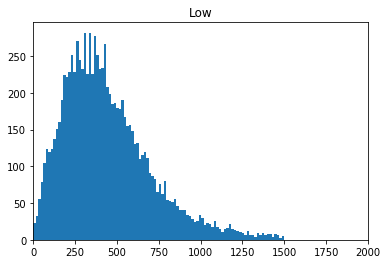

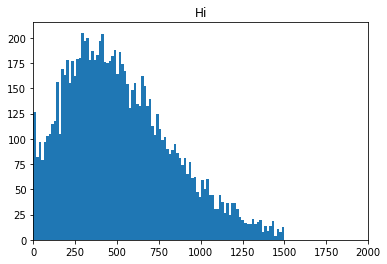

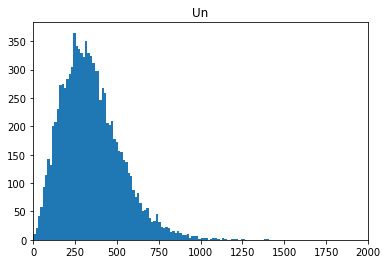

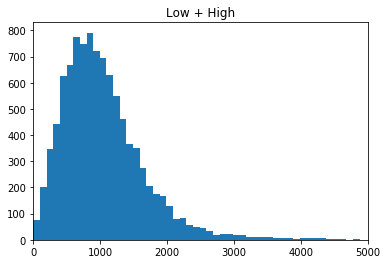

In [5]:
plt.hist( data.loc[ data['LS_reads'] <= 1500, 'LS_reads' ], bins = 100 )
plt.title("Low")
plt.xlim(0,2000)
plt.show()
plt.hist( data.loc[ data['HS_reads'] <= 1500, 'HS_reads' ], bins = 100 )
plt.xlim(0,2000)
plt.title("Hi")
plt.show()
plt.hist( data.loc[ data['US_reads'] <= 1500, 'US_reads' ], bins = 100 )
plt.xlim(0,2000)
plt.title("Un")
plt.show()
combo = data['LS_reads'] + data['HS_reads']
plt.hist( [c for c in combo if c <= 5000], bins = 50 )
plt.xlim(0,5000)
plt.title("Low + High")
plt.show()

In [6]:
combo.shape

(10002,)

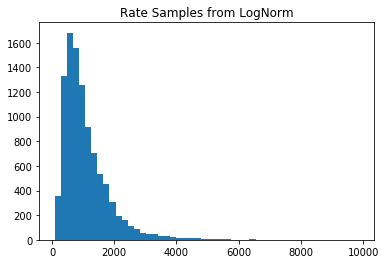

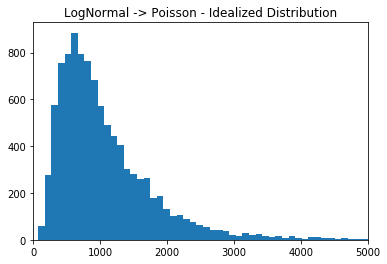

In [20]:
cbo_mu    = combo.mean()
cbo_sigma = combo.var()

lnor_mu = np.log( (cbo_mu**2)/np.sqrt(cbo_sigma-cbo_mu+(cbo_mu**2)) )
lnor_sigma= np.log(1+((cbo_sigma-cbo_mu)/cbo_mu**2))


lam_sample= np.random.lognormal(mean=lnor_mu, sigma=lnor_sigma**0.5, size=combo.shape[0])
cbo_sample= np.random.poisson(lam_sample)

plt.hist(lam_sample,bins=50)
plt.title("Rate Samples from LogNorm")
plt.show()

plt.hist( [c for c in cbo_sample if c < 5000], bins = 50 )
plt.xlim(0,5000)
plt.title("LogNormal -> Poisson - Idealized Distribution")
plt.show()

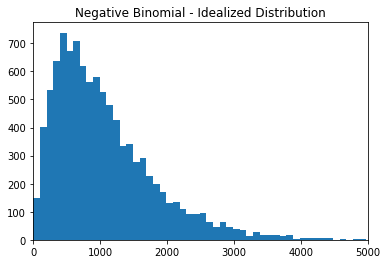

In [7]:
cbo_mu    = combo.mean()
cbo_sigma = combo.var()

cbo_r = (cbo_mu**2)/(cbo_sigma-cbo_mu)
cbo_p = 1 - ((cbo_sigma-cbo_mu)/cbo_sigma) # Numpy correction

cbo_sample = np.random.negative_binomial(cbo_r, cbo_p, combo.shape[0])

plt.hist( [c for c in cbo_sample if c < 5000], bins = 50 )
plt.xlim(0,5000)
plt.title("Negative Binomial - Idealized Distribution")
plt.show()

In [13]:
cbo_sigma / (cbo_mu**2)

0.5070148607949304

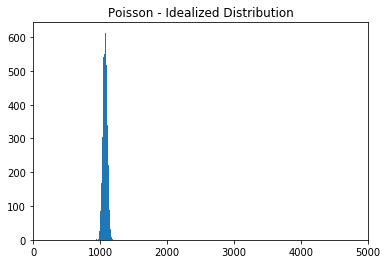

In [14]:
cbo_mu    = combo.mean()
cbo_sigma = combo.var()

cbo_r = (cbo_mu**2)/(cbo_sigma-cbo_mu)
cbo_p = 1 - ((cbo_sigma-cbo_mu)/cbo_sigma) # Numpy correction

cbo_sample = np.random.poisson(cbo_mu, combo.shape[0])

plt.hist( [c for c in cbo_sample if c < 5000], bins = 50 )
plt.xlim(0,5000)
plt.title("Poisson - Idealized Distribution")
plt.show()

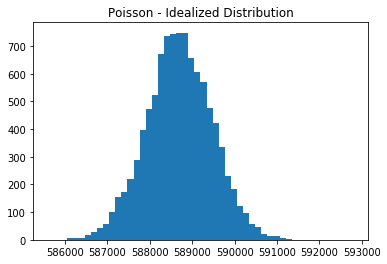

In [16]:
cbo_mu    = combo.mean()
cbo_sigma = combo.var()

cbo_r = (cbo_mu**2)/(cbo_sigma-cbo_mu)
cbo_p = 1 - ((cbo_sigma-cbo_mu)/cbo_sigma) # Numpy correction

cbo_sample = np.random.poisson(cbo_sigma, combo.shape[0])

plt.hist( [c for c in cbo_sample ], bins = 50 )
#plt.xlim(0,5000)
plt.title("Poisson - Idealized Distribution")
plt.show()

In [8]:
cbo_p

0.0018304111850853122

In [9]:
np.mean( data['LS_reads']+data['HS_reads'] )

1077.5686862627474

In [10]:
np.std( data['LS_reads']+data['HS_reads'] )

767.2315248272298

In [11]:
np.std( data['LS_reads']+data['HS_reads'] )**2

588644.2126887161

In [8]:
data[ 'beta_mean' ] = data[ 'LS_reads' ] / ( data[ 'LS_reads' ] + data[ 'HS_reads' ] )
data[ 'log(LS/HS)' ] = np.log( data[ 'LS_reads' ] / data[ 'HS_reads' ] )

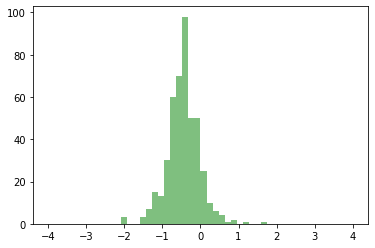

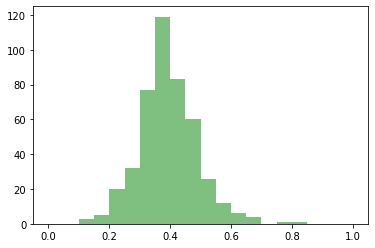

In [9]:
# Non targeting controls, marginal distribution
plt.hist(data['log(LS/HS)'][ data['Coordinates'] == 'NT' ], 50, facecolor='green', alpha=0.5, range=(-4.0,4.0))
plt.show()
plt.hist(data['beta_mean'][ data['Coordinates'] == 'NT' ], 20, facecolor='green', alpha=0.5, range=(0.0,1.0))
plt.show()

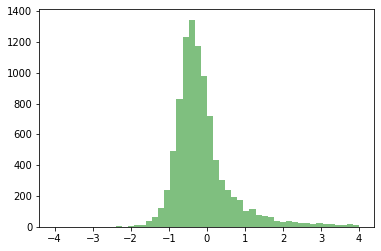

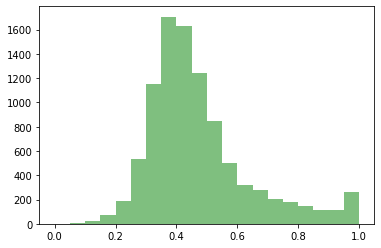

In [10]:
# Targeting guides, marginal distribution
plt.hist(data['log(LS/HS)'][ data['Coordinates'] != 'NT' ], 50, facecolor='green', alpha=0.5, range=(-4.0,4.0))
plt.show()
plt.hist(data['beta_mean'][ data['Coordinates'] != 'NT' ], 20, facecolor='green', alpha=0.5, range=(0.0,1.0))
plt.show()

(array([  3.,  13.,  39., 135., 166.,  73.,  13.,   5.,   1.,   1.]),
 array([-1.96944065, -1.60316464, -1.23688864, -0.87061263, -0.50433663,
        -0.13806063,  0.22821538,  0.59449138,  0.96076739,  1.32704339,
         1.6933194 ]),
 <a list of 10 Patch objects>)

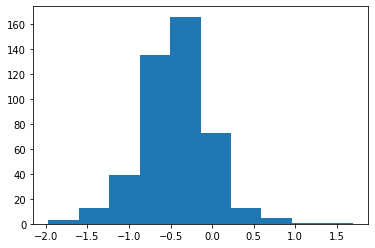

In [11]:
plt.hist( data['log(LS/HS)'][ data['Coordinates'] == "NT" ] )

In [12]:
group1 = data['log(LS/HS)'][ data['Coordinates'] == "NT" ].iloc[:200]
group1 = data['log(LS/HS)'][ data['Coordinates'] == "NT" ].iloc[200:]

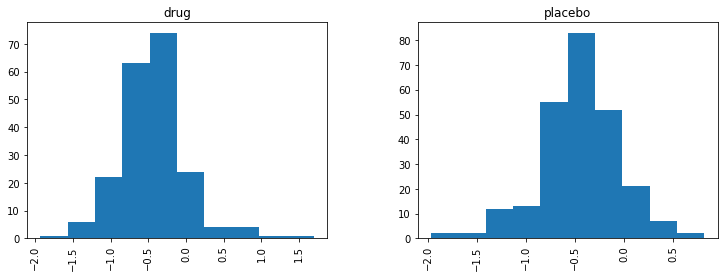

In [13]:
drug = data['log(LS/HS)'][ data['Coordinates'] == "NT" ].iloc[:200]
placebo = data['log(LS/HS)'][ data['Coordinates'] == "NT" ].iloc[200:]

y1 = np.array(drug)
y2 = np.array(placebo)
y = pd.DataFrame(dict(value=np.r_[y1, y2], group=np.r_[['drug']*len(drug), ['placebo']*len(placebo)]))

y.hist('value', by='group', figsize=(12, 4));

In [ ]:
u_m = y.value.mean()
u_s = y.value.std() * 2



In [13]:
u_m = y.value.mean()
u_s = y.value.std() * 2

with pm.Model() as model:
    group1_mean = pm.Normal('group1_mean', mu=u_m, sd=u_s)
    group2_mean = pm.Normal('group2_mean', mu=u_m, sd=u_s)

In [14]:
s_low = 0.5
s_high = 3

with model:
    group1_std = pm.Uniform('group1_std', lower=s_low, upper=s_high)
    group2_std = pm.Uniform('group2_std', lower=s_low, upper=s_high)



In [15]:
with model:
    v = pm.Exponential('v_minus_one', 1/29.) + 1

#sns.kdeplot(np.random.exponential(30, size=10000), fill_kwargs={'alpha': 0.5});

In [16]:
with model:
    l1 = group1_std**-2
    l2 = group2_std**-2

    group1 = pm.StudentT('drug', nu=v, mu=group1_mean, lam=l1, observed=y1)
    group2 = pm.StudentT('placebo', nu=v, mu=group2_mean, lam=l2, observed=y2)


In [17]:
with model:
    diff_of_means = pm.Deterministic('difference of means', group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic('difference of stds', group1_std - group2_std)
    effect_size = pm.Deterministic('effect size',
                                   diff_of_means / np.sqrt((group1_std**2 + group2_std**2) / 2))


In [18]:
with model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v_minus_one, group2_std, group1_std, group2_mean, group1_mean]
Sampling 4 chains: 100%|██████████| 10000/10000 [17:13<00:00,  2.18draws/s]
The acceptance probability does not match the target. It is 0.8831199709848023, but should be close to 0.8. Try to increase the number of tuning steps.


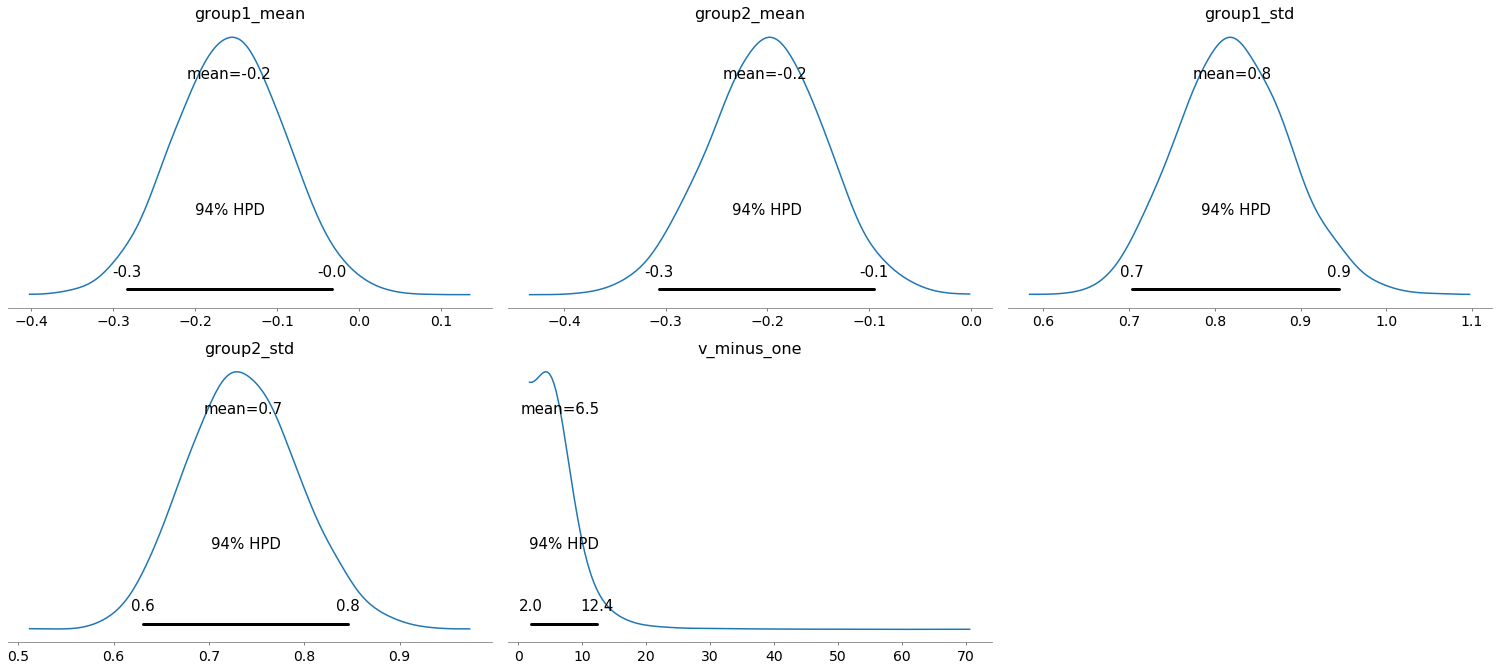

In [20]:
pm.plot_posterior(trace, var_names=['group1_mean','group2_mean', 'group1_std', 'group2_std', 'v_minus_one'],
                  color='#87ceeb');

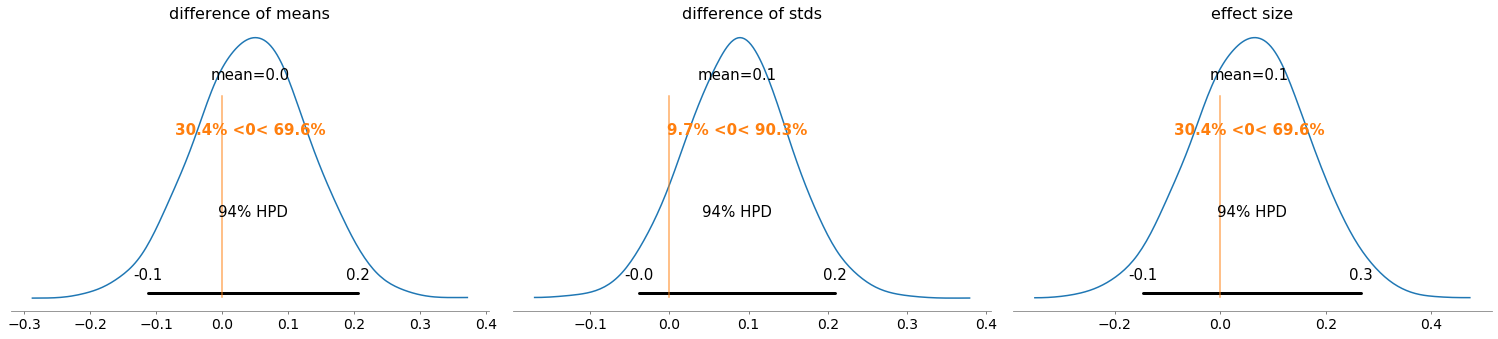

In [21]:
pm.plot_posterior(trace, var_names=['difference of means','difference of stds', 'effect size'],
                  ref_val=0,
                  color='#87ceeb');

In [20]:
#NT_ci = np.percentile( data[ 'beta_mean' ][ data['Coordinates'] == 'NT' ], [2.5,97.5] )
#NT_ci = beta.interval( 0.95, np.sum(data[ 'LS_reads' ][ data['Coordinates'] == 'NT' ]), np.sum(data[ 'HS_reads' ][ data['Coordinates'] == 'NT' ]) )
NT_ci = beta.interval(0.999, np.mean( data['LS_reads'][ data['Coordinates'] == 'NT' ] ), np.mean( data['HS_reads'][ data['Coordinates'] == 'NT' ] ) )
NT_ev = np.mean( data['LS_reads'][ data['Coordinates'] == 'NT' ] ) / ( np.mean( data['LS_reads'][ data['Coordinates'] == 'NT' ] ) + np.mean( data['HS_reads'][ data['Coordinates'] == 'NT' ] ) )

In [21]:
print("NT summary stats")
print("Expectation: {}, CI_lower: {}, CI_upper: {}".format(NT_ev, *NT_ci))

NT summary stats
Expectation: 0.5289875896715414, CI_lower: 0.4505142823140624, CI_upper: 0.6065980505153205


In [22]:
#data['guide_pval'] = beta.cdf(NT_ci[1], data['LS_reads'], data['HS_reads']) - beta.cdf(NT_ci[0], data['LS_reads'], data['HS_reads'])
data['guide_pval'] = two_sided_beta_test(data['LS_reads'].values, data['HS_reads'].values, np.mean( data['LS_reads'][ data['Coordinates'] == 'NT' ] ), np.mean( data['HS_reads'][ data['Coordinates'] == 'NT' ] ))
data['guide_qval'] = multipletests(data['guide_pval'], method='fdr_bh')[1]

In [23]:
p_stack = double_beta_test(data['LS_reads'], data['HS_reads'], np.mean( data['LS_reads'][ data['Coordinates'] == 'NT' ] ), np.mean( data['HS_reads'][ data['Coordinates'] == 'NT' ] ))
#data['low_pval'] = p_stack[:,0]
#data['high_pval'] = p_stack[:,1]
data['low_pval'] = multipletests(p_stack[:,0], method='fdr_bh')[1]
data['high_pval'] = multipletests(p_stack[:,1], method='fdr_bh')[1]

In [24]:
data[0:5]

,Coordinates,US_RPKM,HS_RPKM,LS_RPKM,US_reads,HS_reads,LS_reads,beta_mean,log(LS/HS),guide_pval,guide_qval,low_pval,high_pval
0,NT,52.475390,39.964042,71.547972,287,87,155,0.640496,0.577517,3.826406e-02,6.719270e-02,1.000000e+00,2.660501e-01
1,NT,97.662531,68.444163,58.271029,535,149,127,0.460145,-0.159759,4.616878e-01,6.455707e-01,8.957521e-01,1.000000e+00
2,NT,32.614912,22.508483,26.922690,178,49,59,0.546296,0.185717,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
3,NT,41.543017,2.756141,45.362889,227,6,99,0.942857,2.803360,4.794885e-18,1.874293e-16,1.000000e+00,1.874293e-16
4,NT,57.394958,158.018739,48.866527,314,344,106,0.235556,-1.177203,2.220446e-16,1.697282e-15,2.154572e-15,1.000000e+00


9187
5355
5110


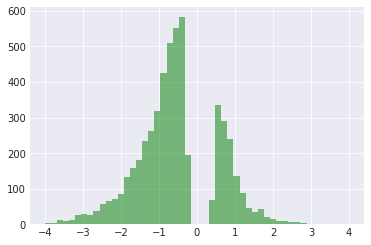

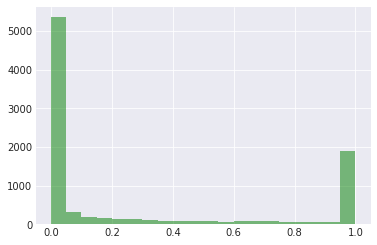

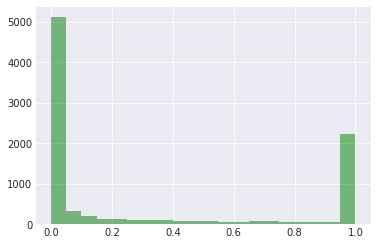

In [25]:
# Analysis of significance in the Targeting guide set
print(np.sum((data['Coordinates'] != 'NT')))
print(np.sum((data['Coordinates'] != 'NT') & (data['guide_pval'] < 0.05)))
print(np.sum((data['Coordinates'] != 'NT') & (data['guide_qval'] < 0.05)))
## Logit score of nominally significant targeting guides
plt.hist(data['log(LS/HS)'][ (data['Coordinates'] != 'NT') & (data['guide_pval'] < 0.05) ], 50, facecolor='green', alpha=0.5, range=(-4.0,4.0))
plt.show()
## Nominal p-value distribution
plt.hist(data['guide_pval'][data['Coordinates'] != 'NT'], 20, facecolor='green', alpha=0.5, range=(0.0,1.0))
plt.show()
## Multiple-test correct p-value distribution
plt.hist(data['guide_qval'][data['Coordinates'] != 'NT'], 20, facecolor='green', alpha=0.5, range=(0.0,1.0))
plt.show()

429
242
228


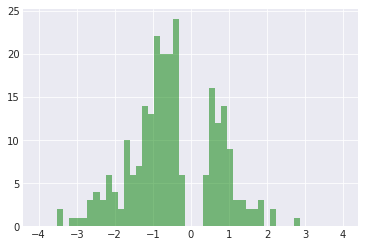

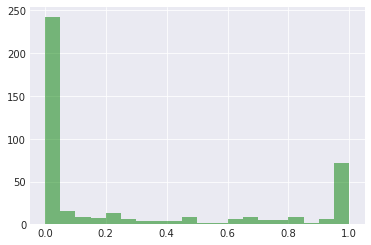

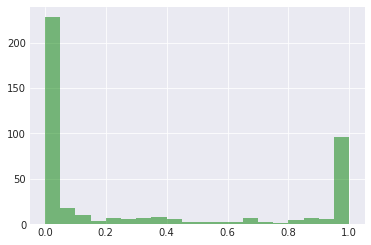

In [26]:
# Analysis of significance in the NT guide set
print(np.sum((data['Coordinates'] == 'NT')))
print(np.sum((data['Coordinates'] == 'NT') & (data['guide_pval'] < 0.05)))
print(np.sum((data['Coordinates'] == 'NT') & (data['guide_qval'] < 0.05)))
## Logit score of nominally significant NT guides
plt.hist(data['log(LS/HS)'][ (data['Coordinates'] == 'NT') & (data['guide_pval'] < 0.05) ], 50, facecolor='green', alpha=0.5, range=(-4.0,4.0))
plt.show()
## Nominal p-value distribution
plt.hist(data['guide_pval'][data['Coordinates'] == 'NT'], 20, facecolor='green', alpha=0.5, range=(0.0,1.0))
plt.show()
## Multiple-test correct p-value distribution
plt.hist(data['guide_qval'][data['Coordinates'] == 'NT'], 20, facecolor='green', alpha=0.5, range=(0.0,1.0))
plt.show()

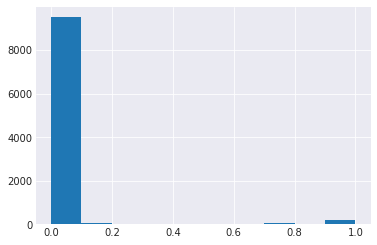

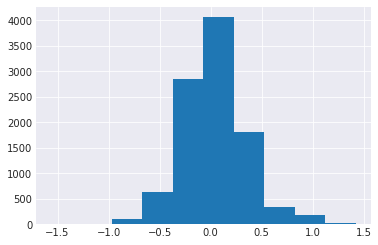

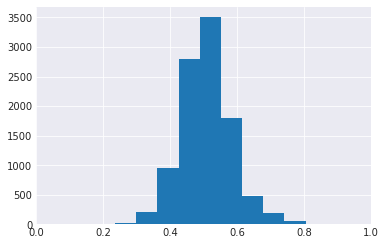

In [27]:
ep = 1e-200 # epsilon for stability
n_samples = 10000
n_per_bin = 10
results   = np.full([n_samples,2], np.nan)

for i in range(n_samples):
    null_check = data[data['Coordinates'] == 'NT'].sample(n=n_per_bin,replace=False)
    frac_score = null_check['LS_reads'].sum() / (null_check.loc[:,('HS_reads','LS_reads')].values.sum())
    if frac_score < NT_ev:
        fishers_score = -2 * np.sum( np.log(null_check['low_pval']+ep) )
    else:
        fishers_score = -2 * np.sum( np.log(null_check['high_pval']+ep) )
    fishers_pvalu = chi2.sf(fishers_score, 2*null_check.shape[0])
    results[i,0] = fishers_pvalu
    results[i,1] = frac_score

plt.hist(results[:,0])
plt.show()
plt.hist(np.log(results[:,1] / (1-results[:,1])))
plt.show()
plt.hist(results[:,1])
plt.xlim((0., 1.))
plt.show()

In [28]:
(results[:,0] < 0.05).mean()

0.9434

In [29]:
data.to_csv("test.txt", sep="\t", quoting=csv.QUOTE_NONE)

In [30]:
!cut -f 2- test.txt > FADS1_rep1_res.txtguidewise.res.txt

In [31]:
!rm test.txt

In [14]:
targ_data = data[ (data['Coordinates'] != 'NT')& (data['Coordinates'] != 'FILLER-LV2') & (data['Coordinates'] != 'FILLER-SgO') ]
plus_offsets = [152, 147]
minus_offsets= [146, 153]
pos_array = np.array([ [ int(coord.split(':')[1].split('-')[1]) - plus_offsets[0],
                         int(coord.split(':')[1].split('-')[1]) + plus_offsets[1] ] if coord.split(':')[2] == '+' 
                       else [ int(coord.split(':')[1].split('-')[1]) - minus_offsets[0],
                              int(coord.split(':')[1].split('-')[1]) + minus_offsets[1] ]
                       for coord in targ_data['Coordinates'] ])

In [15]:
genome_lims = (np.min(pos_array), np.max(pos_array))
print("{}-{}={}".format(genome_lims[1], genome_lims[0], genome_lims[1] - genome_lims[0]))


61897307-61788400=108907


In [17]:
#skippable, specific to locus. 
ep = 1e-200 # epsilon for stability

check_nt = np.mean([61808307   ,     61899307])
check_subset = targ_data[ (pos_array[:,0] <= check_nt) * (pos_array[:,1] > check_nt) ]
low_fish, high_fish = chi2.sf(-2 * (np.sum( np.log(check_subset['low_pval']+ep) )+np.sum( np.log(check_subset['high_pval']+ep) )), 4*check_subset.shape[0]) , chi2.sf(-2 * np.sum( np.log(check_subset['high_pval']+ep) ), 2*check_subset.shape[0])
print("LS total: {}, HS total: {}".format(check_subset['LS_reads'].sum(),check_subset['HS_reads'].sum()))
print("Low Fisher's: {}, High Fisher's: {}".format(low_fish, high_fish)  )
check_subset

KeyError: 'low_pval'

In [16]:
def merge_intervals(intervals):
    sorted_intervals = intervals[ intervals[:,0].argsort() ]
    merged_intervals = sorted_intervals[0:1]
    for i in range(1,sorted_intervals.shape[0]):
        next_interval = sorted_intervals[i:i+1]
        last_interval = merged_intervals[-1:]
        if next_interval[0,0] <= last_interval[0,1]:
            new_max = max( next_interval[0,1], last_interval[0,1] )
            merged_intervals[-1,1] = new_max
        else:
            merged_intervals = np.concatenate([merged_intervals,next_interval], axis=0)
    return merged_intervals

In [17]:
def check_overlap(interval, array):
    height = array.shape[0]
    intervals = np.stack([np.tile(interval,(height,1)), array],axis=0)
    anchor =  (intervals[0,:,0] < intervals[1,:,0]).astype(int)
    return intervals[1-anchor,np.arange(height),1] > intervals[anchor,np.arange(height),0]


In [18]:
sliding_window = np.vstack( (np.arange(*genome_lims,100), 
                             np.minimum(np.arange(*genome_lims,100)+100,genome_lims[1])) ).T

In [19]:
ovl_array = np.stack([ check_overlap(guide_interval,sliding_window) for guide_interval in pos_array ],axis=0).astype(int)
ovl_dex = pd.DataFrame(ovl_array,columns=["wnd_{}".format(i+1) for i in np.arange(ovl_array.shape[1])])
ovl_dex


,wnd_1,wnd_2,wnd_3,wnd_4,wnd_5,wnd_6,wnd_7,wnd_8,wnd_9,wnd_10,...,wnd_1081,wnd_1082,wnd_1083,wnd_1084,wnd_1085,wnd_1086,wnd_1087,wnd_1088,wnd_1089,wnd_1090
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
targ_data.loc[:,('Coordinates','HS_reads','LS_reads')]

,Coordinates,HS_reads,LS_reads
449,chr11:61788524-61788546:-,661,427
450,chr11:61788527-61788549:-,716,402
451,chr11:61788560-61788582:+,1103,736
452,chr11:61788568-61788590:+,886,400
453,chr11:61788568-61788590:-,803,410
454,chr11:61788583-61788605:-,372,128
455,chr11:61788622-61788644:+,497,529
456,chr11:61788630-61788652:+,346,212
457,chr11:61788645-61788667:-,535,244
458,chr11:61788663-61788685:-,337,230


In [21]:
hold = pd.concat((targ_data.loc[:,('Coordinates','HS_reads','LS_reads')].reset_index(drop=True),
                  ovl_dex.reset_index(drop=True)),axis=1)
hold

,Coordinates,HS_reads,LS_reads,wnd_1,wnd_2,wnd_3,wnd_4,wnd_5,wnd_6,wnd_7,...,wnd_1081,wnd_1082,wnd_1083,wnd_1084,wnd_1085,wnd_1086,wnd_1087,wnd_1088,wnd_1089,wnd_1090
0,chr11:61788524-61788546:-,661,427,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,chr11:61788527-61788549:-,716,402,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,chr11:61788560-61788582:+,1103,736,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,chr11:61788568-61788590:+,886,400,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,chr11:61788568-61788590:-,803,410,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,chr11:61788583-61788605:-,372,128,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,chr11:61788622-61788644:+,497,529,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,chr11:61788630-61788652:+,346,212,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,chr11:61788645-61788667:-,535,244,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9,chr11:61788663-61788685:-,337,230,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
coeff_ct = ( hold.iloc[:,3:].values.sum(0) > 0 ).shape[0]
coeff_ct

(1090,)

In [67]:
with pm.Model() as model:
    g = pm.Gamma('guide_intensity',mu=ct_mean,sigma=ct_sd)

    e = pm.Normal('activity_coefficients', mu=e_mean, sigma=e_sd, shape=coeff_ct)
    s = pm.Constant('factors',c=)
    t = pm.math.dot()
    c = pm.Flat('intercept')
    p = pm.Deterministic('bin_bias', tt.nnet.sigmoid(c+e))

    l = pm.Deterministic('low_bin_theta', g*p[slicer] )
    h = pm.Deterministic('high_bin_theta', g*(1-p[slicer]) )

    diff = pm.Deterministic('enhancer_boost', e[1]-e[0])

    l_ct = pm.Poisson('low_reads', mu=l, observed=use_data['LS_reads'])
    h_ct = pm.Poisson('high_reads', mu=h, observed=use_data['HS_reads'])

with model:
    trace = pm.sample(1000, tune=1000, cores=8)



array([[61788400, 61788699],
       [61788400, 61788699],
       [61788400, 61788699],
       ...,
       [61788400, 61788699],
       [61788400, 61788699],
       [61788400, 61788699]])

In [64]:
pos_array[0][1 - (pos_array[0][0] < sliding_window[:,0]).astype(int)]

array([61788699, 61788400, 61788400, ..., 61788400, 61788400, 61788400])

In [47]:
check_overlap( pos_array[0], pos_array[1] )

True

In [50]:
genome_lims

(61788400, 61897307)

In [53]:
np.arange(*genome_lims,100)

array([61788400, 61788500, 61788600, ..., 61897100, 61897200, 61897300])

In [52]:
np.minimum(np.arange(*genome_lims,100)+100,genome_lims[1])

array([61788500, 61788600, 61788700, ..., 61897200, 61897300, 61897307])

array([[61788400, 61788500],
       [61788500, 61788600],
       [61788600, 61788700],
       ...,
       [61897100, 61897200],
       [61897200, 61897300],
       [61897300, 61897307]])

In [36]:
# Convert per-guide data to genomic interval data
nt_data = np.zeros( shape=[0, 5] )
last_start    = genome_lims[0]
last_subset = targ_data[ (pos_array[:,0] <= last_start) * (pos_array[:,1] > last_start) ]
ep = 1e-200 # epsilon for stability
merged_pos = merge_intervals(pos_array)


In [42]:
merged_pos[1:,0] - merged_pos[:-1,1]

array([ 30, 131,  34,  38,  55, 173,  34,  34, 160, 171,   6,  40])

In [73]:
# Convert per-guide data to genomic interval data
nt_data = np.zeros( shape=[0, 5] )
last_start    = genome_lims[0]
last_subset = targ_data[ (pos_array[:,0] <= last_start) * (pos_array[:,1] > last_start) ]
ep = 1e-200 # epsilon for stability
merged_pos = merge_intervals(pos_array)

for i, segment in enumerate( merged_pos ):
    if i == (merged_pos.shape[0]-1):
        segment[1] += 1
    for j, nt_pos in enumerate( range(*segment) ):
        nt_subset = targ_data[ (pos_array[:,0] <= nt_pos) * (pos_array[:,1] > nt_pos) ]
        if not nt_subset['Coordinates'].equals(last_subset['Coordinates']):
            if np.sum( last_subset[ 'HS_reads' ] ) == 0 or np.sum( last_subset[ 'LS_reads' ] ) == 0:
                if last_subset.shape[0] >= 1:
                    print(nt_pos)
                    print(last_subset)
            if last_subset.shape[0] == 1:
                fishers_pvalu = last_subset['guide_pval']
                logit_score = np.log( np.sum(last_subset[ 'LS_reads' ]) / np.sum(last_subset[ 'HS_reads' ]) )
            elif last_subset.shape[0] > 1:
                if last_subset[ 'LS_reads' ].sum() / (last_subset[ 'LS_reads' ].sum() + last_subset[ 'HS_reads' ].sum()) < NT_ev:
                    fishers_score = -2 * np.sum( np.log(last_subset['low_pval']+ep) )
                else:
                    fishers_score = -2 * np.sum( np.log(last_subset['high_pval']+ep) )
                fishers_pvalu = chi2.sf(fishers_score, 2*last_subset.shape[0])
                logit_score = np.log( np.sum(last_subset[ 'LS_reads' ]) / np.sum(last_subset[ 'HS_reads' ]) )
            else:
                fishers_pvalu = np.nan
                logit_score   = np.nan
            new_entry = np.array([[last_start, last_nt+1, last_subset.shape[0], logit_score, fishers_pvalu]])
            nt_data = np.concatenate([nt_data,new_entry])
            last_start = nt_pos
        last_subset = nt_subset
        last_nt     = nt_pos
    if i % 20 == 0:
        print("On chunk [{}/{}]".format(i,merged_pos.shape[0]))

#nt_data = nt_data[ nt_data[:,2] != 0 ]

On chunk [0/13]


In [74]:
nt_data = np.hstack([nt_data[:,:5], np.expand_dims( multipletests(nt_data[:,4], method='fdr_bh')[1],axis=1 )])
print(np.sum( nt_data[:,4] < 0.05 ))
print(np.sum( nt_data[:,5] < 0.05 ))

16862
16862


In [75]:
nt_data.shape

(17061, 6)

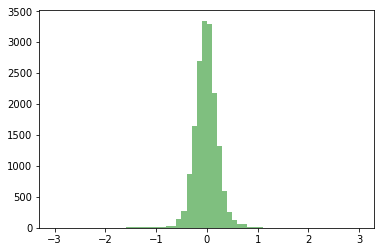

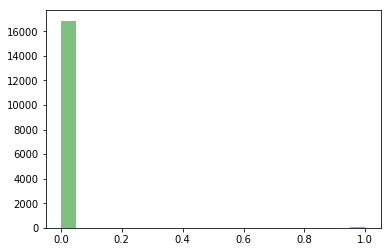

In [76]:
# P-value (and q-value) distribution
plt.hist(nt_data[:,3], 60, facecolor='green', alpha=0.5, range=(-3.0,3.0))
plt.show()
plt.hist(nt_data[:,4], 20, facecolor='green', alpha=0.5, range=(0.0,1.0))
plt.show()

In [77]:
nt_data = pd.DataFrame(nt_data,columns=["start","stop","guide_count","score","pvalue","qvalue"])
nt_data[["start","stop","guide_count"]] = nt_data[["start","stop","guide_count"]].astype(np.int64)

In [78]:
nt_data.to_csv("test.txt", sep="\t", quoting=csv.QUOTE_NONE)

In [79]:
!cut -f 2- test.txt > FADS1_rep1_detailed_bp-sig.res.txt

In [80]:
!rm test.txt

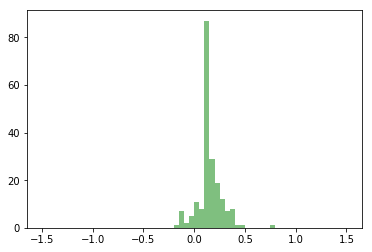

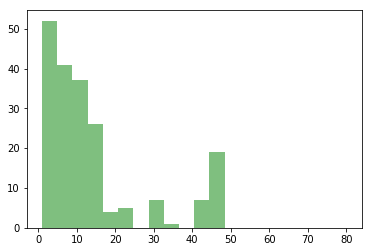

In [81]:
# Non-significant regions
## Scores
plt.hist(nt_data.loc[nt_data['qvalue'] >= 0.05]['score'], 60, facecolor='green', alpha=0.5, range=(-1.5,1.5))
plt.show()
## Guide counts
plt.hist(nt_data.loc[nt_data['qvalue'] >= 0.05]['guide_count'], 20, facecolor='green', alpha=0.5, range=(1,80))
plt.show()

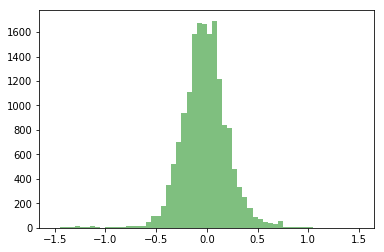

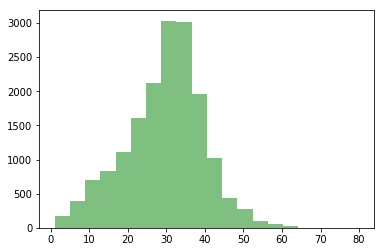

In [82]:
# Significant regions
## Scores
plt.hist(nt_data.loc[nt_data['qvalue'] < 0.05]['score'], 60, facecolor='green', alpha=0.5, range=(-1.5,1.5))
plt.show()
## Guide counts
plt.hist(nt_data.loc[nt_data['qvalue'] < 0.05]['guide_count'], 20, facecolor='green', alpha=0.5, range=(1,80))
plt.show()


# Remodeling with PyMC3

In [1]:
# Reset notebook to make sure above variables don't interfere
%reset -f

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


In [2]:
import numpy as np
import pandas as pd
import pymc3 as pm, theano.tensor as tt
from theano import shared
import os
import glob
import csv
import pickle
from scipy.stats import beta
from scipy.stats import bernoulli
from scipy.stats import chi2
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
import seaborn as sns

In [3]:
def double_beta_test(test_alpha, test_beta, null_alpha, null_beta, interval_size=0.95):
    null_ci = beta.interval( interval_size, null_alpha, null_beta )
    null_ev = float(null_alpha) / float(null_alpha + null_beta)
    p_stack = 2 * np.vstack( (beta.sf(null_ci[0], test_alpha, test_beta) , 
                              beta.cdf(null_ci[1], test_alpha, test_beta)) )
    return np.clip( p_stack.T, 0.0, 1.0 )

def two_sided_beta_test(test_alpha, test_beta, null_alpha, null_beta, interval_size=0.95):
    null_ci = beta.interval( interval_size, null_alpha, null_beta )
    null_ev = float(null_alpha) / float(null_alpha + null_beta)
    p_stack = 2 * np.vstack( (beta.sf(null_ci[0], test_alpha, test_beta) , 
                              beta.cdf(null_ci[1], test_alpha, test_beta)) )
    ev_check = ( test_alpha / (test_alpha + test_beta) ) >= null_ev
    p_value = p_stack.T[ np.arange( test_alpha.shape[0] ) , ev_check.astype(np.int) ]
    return np.clip( p_value, 0.0, 1.0 )

In [5]:
data = pd.read_table('../data/FADS1_rep8detailed.txt', sep="\t", header=0)
print(data[0:4])
print(data.shape)
hs_zero = data['HS_reads'] > 0
ls_zero = data['LS_reads'] > 0
rm_zero = hs_zero * ls_zero
data = data[ rm_zero ]
print(data[0:4])
print(data.shape)
print("LS lib size: {}".format(data['LS_reads'].sum()))
print("HS lib size: {}".format(data['HS_reads'].sum()))
DOWNSAMPLED_FLAG = False

  Coordinates    US_RPKM     HS_RPKM    LS_RPKM  US_reads  HS_reads  LS_reads
0          NT  27.076072   40.385938  21.937587        93       298       117
1          NT  70.570614  130.207507  18.777087       244       963       100
2          NT  78.923870   44.708179  63.581821       273       330       341
3          NT  50.983668   26.203585  21.937587       176       193       117
(10002, 7)
  Coordinates    US_RPKM     HS_RPKM    LS_RPKM  US_reads  HS_reads  LS_reads
0          NT  27.076072   40.385938  21.937587        93       298       117
1          NT  70.570614  130.207507  18.777087       244       963       100
2          NT  78.923870   44.708179  63.581821       273       330       341
3          NT  50.983668   26.203585  21.937587       176       193       117
(9965, 7)
LS lib size: 5332657
HS lib size: 7403362


/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.
/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [6]:
# Rescaling larger library
if not DOWNSAMPLED_FLAG:
    ## Rescale to floats
    rescale = min(data['LS_reads'].sum(),data['HS_reads'].sum()) / data.loc[:,('HS_reads','LS_reads')].sum(axis=0)
    data.loc[:,('HS_reads','LS_reads')] *= rescale
    ## Sample downsized library
    runif              = np.random.uniform(size=data.loc[:,('HS_reads','LS_reads')].shape)
    int_part, sample_p = np.divmod( data.loc[:,('HS_reads','LS_reads')], 1 )
    data.loc[:,('HS_reads','LS_reads')] = int_part + (runif < sample_p)
    ## Return as int
    data.loc[:,('HS_reads','LS_reads')] = data.loc[:,('HS_reads','LS_reads')].astype(int) + 1
    DOWNSAMPLED_FLAG = True
else:
    print("Already downsampled")

print("LS lib size: {}".format(data['LS_reads'].sum()))
print("HS lib size: {}".format(data['HS_reads'].sum()))


LS lib size: 5342622
HS lib size: 5342634


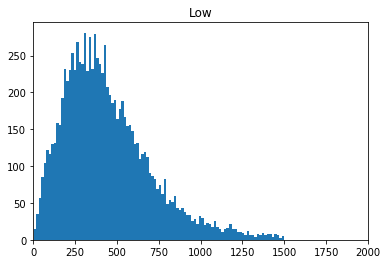

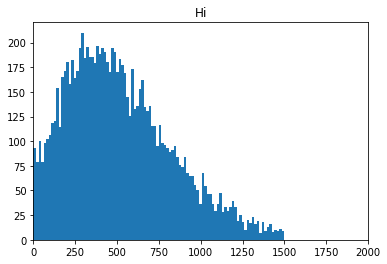

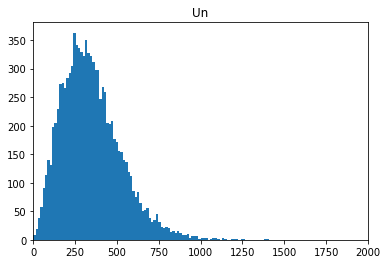

In [7]:
plt.hist( data.loc[ data['LS_reads'] <= 1500, 'LS_reads' ], bins = 100 )
plt.title("Low")
plt.xlim(0,2000)
plt.show()
plt.hist( data.loc[ data['HS_reads'] <= 1500, 'HS_reads' ], bins = 100 )
plt.xlim(0,2000)
plt.title("Hi")
plt.show()
plt.hist( data.loc[ data['US_reads'] <= 1500, 'US_reads' ], bins = 100 )
plt.xlim(0,2000)
plt.title("Un")
plt.show()

In [8]:
np.mean( data['LS_reads']+data['HS_reads'] )

1072.2785750125438

In [9]:
np.std( data['LS_reads']+data['HS_reads'] )

762.77653820296

In [10]:
data[ 'beta_mean' ] = data[ 'LS_reads' ] / ( data[ 'LS_reads' ] + data[ 'HS_reads' ] )
data[ 'log(LS/HS)' ] = np.log( data[ 'LS_reads' ] / data[ 'HS_reads' ] )

951.8418708240534


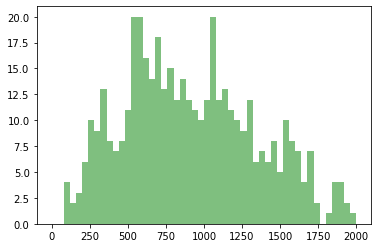

-0.4468756808694761


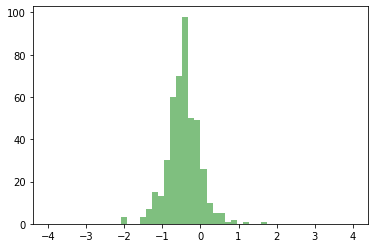

0.3941212982274994


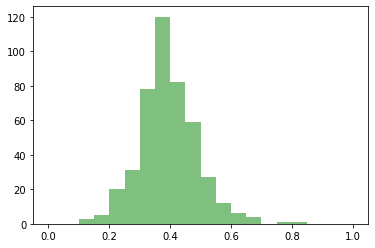

In [11]:
# Non targeting controls, marginal distribution
print(np.mean(data.loc[:,('HS_reads','LS_reads')][ data['Coordinates'] == 'NT' ].sum(1)))
plt.hist(data.loc[:,('HS_reads','LS_reads')][ data['Coordinates'] == 'NT' ].sum(1), 50, facecolor='green', alpha=0.5, range=(0,2000))
plt.show()
print(np.mean(data['log(LS/HS)'][ data['Coordinates'] == 'NT' ]))
plt.hist(data['log(LS/HS)'][ data['Coordinates'] == 'NT' ], 50, facecolor='green', alpha=0.5, range=(-4.0,4.0))
plt.show()
print(np.mean(data['beta_mean'][ data['Coordinates'] == 'NT' ]))
plt.hist(data['beta_mean'][ data['Coordinates'] == 'NT' ], 20, facecolor='green', alpha=0.5, range=(0.0,1.0))
plt.show()

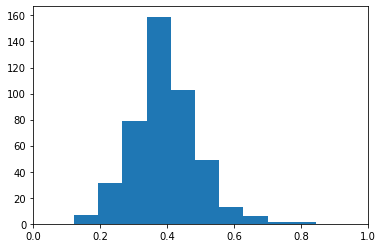

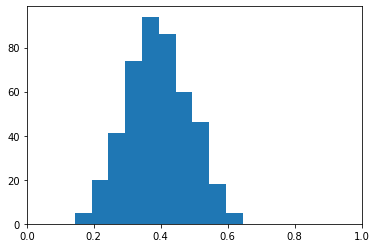

0.3941212982274994 0.09592394012368076


In [48]:
NT_data = data[ data['Coordinates'] == 'NT' ]
odds_ratios = NT_data['LS_reads'] / (NT_data['LS_reads']+NT_data['HS_reads'])
plt.hist(odds_ratios)
plt.xlim(0,1)
plt.show()
b_alpha = (odds_ratios.mean()**2)*(((1-odds_ratios.mean())/odds_ratios.var())-(1/odds_ratios.mean()))
b_beta  = b_alpha*((1/odds_ratios.mean())-1)
b_theo  = np.random.beta(b_alpha,b_beta,odds_ratios.shape[0])
plt.hist(b_theo)
plt.xlim(0,1)
plt.show()
print(odds_ratios.mean(),odds_ratios.std())

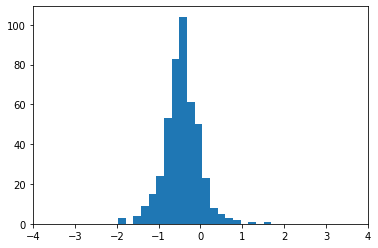

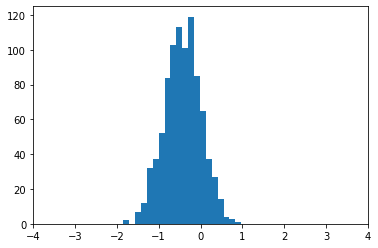

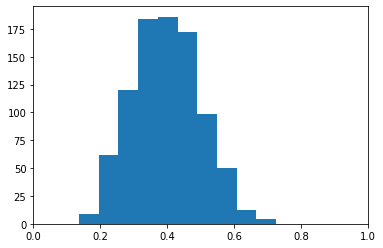

0.39853779810373063
0.09960797757032122


In [47]:
lods_ = np.log(NT_data['LS_reads'] / NT_data['HS_reads'])
plt.hist(lods_,bins=20)
plt.xlim(-4,4)
plt.show()
l_theo = np.random.normal(lods_.mean(),lods_.std(),2*lods_.shape[0])
plt.hist(l_theo,bins=20)
plt.xlim(-4,4)
plt.show()
plt.hist(np.exp(l_theo)/(1+np.exp(l_theo)))
plt.xlim(0,1)
plt.show()
print(np.mean(np.exp(l_theo)/(1+np.exp(l_theo))))
print(np.std(np.exp(l_theo)/(1+np.exp(l_theo))))

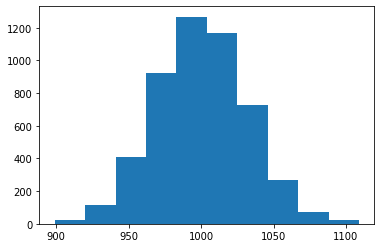

In [50]:
plt.hist(np.random.poisson(1000,5000))
plt.show()

In [28]:
b_alpha = (odds_ratios.mean()**2)*(((1-odds_ratios.mean())/odds_ratios.var())-(1/odds_ratios.mean()))
b_beta  = b_alpha*((1/odds_ratios.mean())-1)

1077.9612232030265


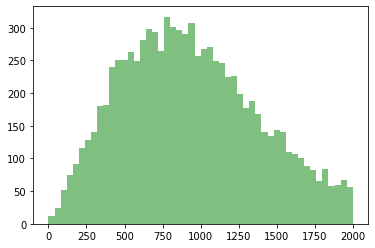

-0.03021657063381878


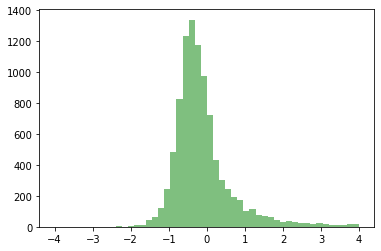

0.4725475828187839


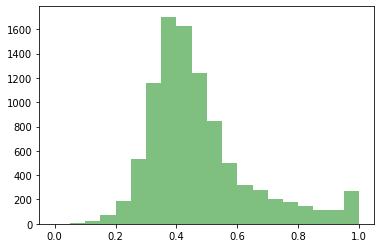

In [12]:
# Targeting guides, marginal distribution
print(np.mean(data.loc[:,('HS_reads','LS_reads')][ data['Coordinates'] != 'NT' ].sum(1)))
plt.hist(data.loc[:,('HS_reads','LS_reads')][ data['Coordinates'] != 'NT' ].sum(1), 50, facecolor='green', alpha=0.5, range=(0,2000))
plt.show()
print(np.mean(data['log(LS/HS)'][ data['Coordinates'] != 'NT' ]))
plt.hist(data['log(LS/HS)'][ data['Coordinates'] != 'NT' ], 50, facecolor='green', alpha=0.5, range=(-4.0,4.0))
plt.show()
print(np.mean(data['beta_mean'][ data['Coordinates'] != 'NT' ]))
plt.hist(data['beta_mean'][ data['Coordinates'] != 'NT' ], 20, facecolor='green', alpha=0.5, range=(0.0,1.0))
plt.show()

(array([  3.,  13.,  39., 136., 165.,  73.,  13.,   5.,   1.,   1.]),
 array([-1.97155258, -1.60506538, -1.23857818, -0.87209099, -0.50560379,
        -0.13911659,  0.22737061,  0.5938578 ,  0.960345  ,  1.3268322 ,
         1.6933194 ]),
 <a list of 10 Patch objects>)

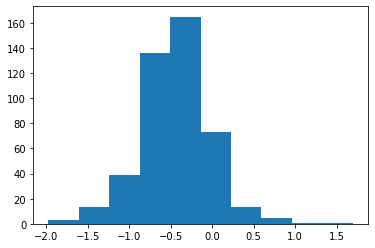

In [13]:
plt.hist( data['log(LS/HS)'][ data['Coordinates'] == "NT" ] )

In [14]:
targ_data = data[ (data['Coordinates'] != 'NT')& (data['Coordinates'] != 'FILLER-LV2') & (data['Coordinates'] != 'FILLER-SgO') ]
plus_offsets = [152, 147]
minus_offsets= [146, 153]
pos_array = np.array([ [ int(coord.split(':')[1].split('-')[1]) - plus_offsets[0],
                         int(coord.split(':')[1].split('-')[1]) + plus_offsets[1] ] if coord.split(':')[2] == '+' 
                       else [ int(coord.split(':')[1].split('-')[1]) - minus_offsets[0],
                              int(coord.split(':')[1].split('-')[1]) + minus_offsets[1] ]
                       for coord in targ_data['Coordinates'] ])

In [15]:
genome_lims = (np.min(pos_array), np.max(pos_array))
print("{}-{}={}".format(genome_lims[1], genome_lims[0], genome_lims[1] - genome_lims[0]))


61897307-61788400=108907


In [16]:
def check_overlap(interval, array):
    height = array.shape[0]
    intervals = np.stack([np.tile(interval,(height,1)), array],axis=0)
    anchor =  (intervals[0,:,0] < intervals[1,:,0]).astype(int)
    return intervals[1-anchor,np.arange(height),1] > intervals[anchor,np.arange(height),0]


In [17]:
sliding_window = np.vstack( (np.arange(*genome_lims,100), 
                             np.minimum(np.arange(*genome_lims,100)+100,genome_lims[1])) ).T
sliding_window.shape

(1090, 2)

In [18]:
sliding_window = sliding_window[[ np.any(check_overlap(interval,pos_array)) for 
                                  interval in sliding_window ]]
sliding_window.shape

(1088, 2)

In [19]:
get_a_peak = np.argmax( sliding_window[:,1] > 61815500 ) + 1
print(get_a_peak)
sliding_window[np.argmax( sliding_window[:,1] > 61815500 )]

272


array([61815500, 61815600])

In [20]:
ovl_array = np.stack([ check_overlap(guide_interval,sliding_window) for guide_interval in pos_array ],axis=0).astype(int)
ovl_array = np.concatenate((np.zeros_like(ovl_array[:,0:1]),ovl_array),axis=1)
ovl_dex = pd.DataFrame(ovl_array,columns=["wnd_{}".format(i) for i in np.arange(ovl_array.shape[1])])



In [21]:
NT_count = data.loc[(data['Coordinates'] == 'NT'),('Coordinates','HS_reads','LS_reads')].shape[0]
NT_hold = np.zeros((NT_count,ovl_array.shape[1])).astype(int)
NT_hold[:,0] = 1
NT_dex = pd.DataFrame(NT_hold,columns=["wnd_{}".format(i) for i in np.arange(ovl_array.shape[1])])

In [22]:
wind_data = pd.concat((
    pd.concat((data.loc[(data['Coordinates'] == 'NT'),('Coordinates','HS_reads','LS_reads')].reset_index(drop=True),
           NT_dex.reset_index(drop=True)),axis=1).reset_index(drop=True)
    ,
    pd.concat((targ_data.loc[:,('Coordinates','HS_reads','LS_reads')].reset_index(drop=True),
               ovl_dex.reset_index(drop=True)),axis=1).reset_index(drop=True)
), axis=0, ignore_index=True)
max_idx = max([ int(item.replace('wnd_','')) for item in wind_data.columns if 'wnd' in item ])


In [23]:
wind_data

,Coordinates,HS_reads,LS_reads,wnd_0,wnd_1,wnd_2,wnd_3,wnd_4,wnd_5,wnd_6,...,wnd_1079,wnd_1080,wnd_1081,wnd_1082,wnd_1083,wnd_1084,wnd_1085,wnd_1086,wnd_1087,wnd_1088
0,NT,215,118,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NT,695,101,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NT,239,342,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NT,140,118,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NT,769,513,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,NT,304,333,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,NT,354,312,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,NT,817,396,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,NT,346,305,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,NT,786,754,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(0, 100)

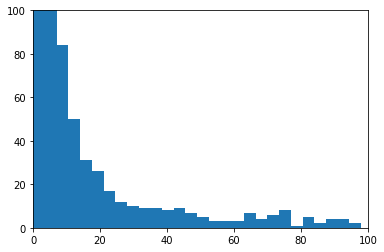

In [46]:
plt.hist(wind_data['LS_reads'] / wind_data['HS_reads'],bins=1000)
plt.xlim(0,100)
plt.ylim(0,100)

In [47]:
df_list = [ (wind_data.loc[wind_data['wnd_{}'.format(idx)] == 1,('HS_reads','LS_reads')].copy().reset_index(drop=True),
             idx) 
           for idx in range(max_idx+1) ]

In [48]:
df_list = [pd.concat([df, 
                      pd.DataFrame(np.full((df.shape[0],1), idx),columns=['wnd_idx']).reset_index(drop=True)
                     ],
                     axis=1) 
           for df, idx in df_list]

In [49]:
expanded_data = pd.concat([df.reset_index(drop=True) for df in df_list]).reset_index(drop=True)
e_mean = np.mean(np.log(expanded_data['LS_reads'] / expanded_data['HS_reads']))
e_sd   = np.std(np.log(expanded_data['LS_reads'] / expanded_data['HS_reads']))
ct_mean = np.mean(expanded_data['LS_reads'].values+ expanded_data['HS_reads'].values)
ct_sd   = np.std(expanded_data['LS_reads'].values+ expanded_data['HS_reads'].values)


In [50]:
group0 =  (wind_data['wnd_0'] == 1).astype(int)
group1 =  (wind_data['wnd_{}'.format(get_a_peak)] == 1).astype(int)
slicer = np.vstack([group0, group1]).T
use_data = wind_data[ np.sum(slicer,axis=1) == 1 ]
slicer = slicer[ np.sum(slicer,axis=1) == 1 ]
slicer = np.argmax(slicer, axis=1)

-0.1670837263148233
1.0527861183036091


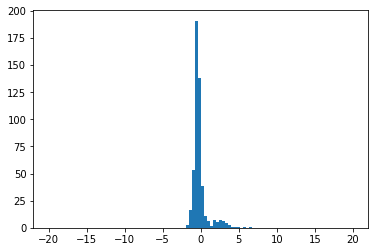

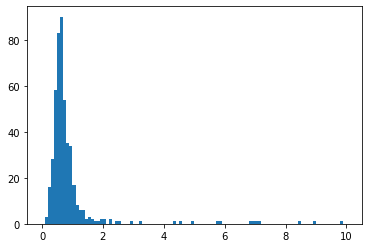

In [51]:
e_mean = np.mean(np.log(use_data['LS_reads'] / use_data['HS_reads']))
e_sd   = np.std(np.log(use_data['LS_reads'] / use_data['HS_reads']))
print(e_mean)
print(e_sd)
plt.hist(np.log(use_data['LS_reads'] / use_data['HS_reads']), bins=100, range=(-20,20))
plt.show()
plt.hist((use_data['LS_reads'] / use_data['HS_reads']), bins=100, range=(0,10))
plt.show()

(array([ 1.,  3.,  5.,  8., 12., 10.,  3.,  3.,  0.,  2.]),
 array([-0.85502693, -0.11342117,  0.62818459,  1.36979035,  2.11139611,
         2.85300187,  3.59460763,  4.33621339,  5.07781915,  5.81942491,
         6.56103067]),
 <a list of 10 Patch objects>)

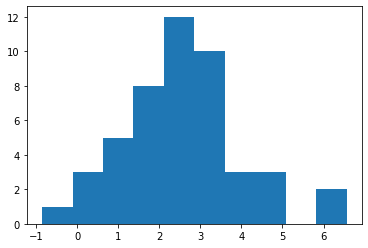

In [52]:
plt.hist(np.log(use_data[use_data['Coordinates'] != 'NT']['LS_reads'] / use_data[use_data['Coordinates'] != 'NT']['HS_reads']))


1080.453629032258
745.0071889313624


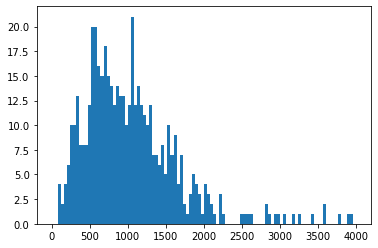

In [53]:
ct_mean = np.mean(use_data['LS_reads'].values+ use_data['HS_reads'].values)
ct_sd   = np.std(use_data['LS_reads'].values+ use_data['HS_reads'].values)
print(ct_mean)
print(ct_sd)
plt.hist(use_data['LS_reads'].values+ use_data['HS_reads'].values, bins=100, range=(0,4000));

In [54]:
slicer.shape

(496,)

In [57]:
wind_data

,Coordinates,HS_reads,LS_reads,wnd_0,wnd_1,wnd_2,wnd_3,wnd_4,wnd_5,wnd_6,...,wnd_1079,wnd_1080,wnd_1081,wnd_1082,wnd_1083,wnd_1084,wnd_1085,wnd_1086,wnd_1087,wnd_1088
0,NT,216,118,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NT,694,101,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NT,238,342,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NT,140,118,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NT,768,513,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,NT,304,333,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,NT,355,312,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,NT,816,396,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,NT,346,305,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,NT,787,754,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
with pm.Model() as model:
    low_observed = shared(np.zeros(100))
    high_observed = shared(np.zeros(100))
    
    g = pm.Gamma('guide_intensity',mu=ct_mean,sigma=ct_sd)
    
    e = pm.Normal('enhancer_activity', mu=e_mean, sigma=e_sd, shape=2)
    p = pm.Deterministic('bin_bias', tt.nnet.sigmoid(e))
    
    l = pm.Deterministic('low_bin_theta', g*p[slicer] )
    h = pm.Deterministic('high_bin_theta', g*(1-p[slicer]) )
    
    diff = pm.Deterministic('enhancer_boost', e[1]-e[0])
    
    l_ct = pm.Poisson('low_reads', mu=l, observed=low_observed)
    h_ct = pm.Poisson('high_reads', mu=h, observed=high_observed)
    
def fit(data):
    low_observed.set_value(  ['LS_reads'] )
    high_observed.set_value( ['HS_reads'] )
    trace = pm.sample(2000, tune=1000, cores=4)
    return trace
    
def extract_data(window_data, win_idx):    
    group0 =  (window_data['wnd_0'] == 1).astype(int)
    group1 =  (window_data['wnd_{}'.format(win_idx)] == 1).astype(int)
    slicer = np.vstack([group0, group1]).T
    use_data = window_data[ np.sum(slicer,axis=1) == 1 ]
    slicer = slicer[ np.sum(slicer,axis=1) == 1 ]
    slicer = np.argmax(slicer, axis=1)
    
    
    

KeyboardInterrupt: 

In [24]:
def call_window(window_data, win_idx):
    print("Starting wnd_{}".format(win_idx))
    group0 =  (window_data['wnd_0'] == 1).astype(int)
    group1 =  (window_data['wnd_{}'.format(win_idx)] == 1).astype(int)
    slicer = np.vstack([group0, group1]).T
    use_data = window_data[ np.sum(slicer,axis=1) == 1 ]
    slicer = slicer[ np.sum(slicer,axis=1) == 1 ]
    slicer = np.argmax(slicer, axis=1)
    e_mean = np.mean(np.log(use_data['LS_reads'] / use_data['HS_reads']))
    e_sd   = np.std(np.log(use_data['LS_reads'] / use_data['HS_reads']))
    ct_mean = np.mean(use_data['LS_reads'].values+ use_data['HS_reads'].values)
    ct_sd   = np.std(use_data['LS_reads'].values+ use_data['HS_reads'].values)

    with pm.Model() as model:
        g = pm.Gamma('guide_intensity',mu=ct_mean,sigma=ct_sd)

        e = pm.Normal('enhancer_activity', mu=e_mean, sigma=e_sd, shape=2)
        p = pm.Deterministic('bin_bias', tt.nnet.sigmoid(e))

        l = pm.Deterministic('low_bin_theta', g*p[slicer] )
        h = pm.Deterministic('high_bin_theta', g*(1-p[slicer]) )
        
        diff = pm.Deterministic('enhancer_boost', e[1]-e[0])

        l_ct = pm.Poisson('low_reads', mu=l, observed=use_data['LS_reads'])
        h_ct = pm.Poisson('high_reads', mu=h, observed=use_data['HS_reads'])
    
    with model:
        trace = pm.sample(2000, tune=1000, cores=4)

    hdr = pm.stats.hpd(trace['enhancer_activity'],alpha=0.001)
    one_call = check_overlap(hdr[0],hdr[1:2])[0]
    
    hdr = pm.stats.hpd(trace['enhancer_boost'],alpha=0.001)
    two_call = check_overlap(np.array([-0.5,0.5]),np.expand_dims(hdr,axis=0))[0]
    print(two_call)
    return (hdr, two_call)


In [25]:
from multiprocessing import Pool
from itertools import repeat

with Pool(20) as p:
    peak_calls = p.starmap(call_window, zip(repeat(wind_data, max_idx),range(1,max_idx+1)))

Starting wnd_1
Starting wnd_15
Starting wnd_29
Starting wnd_43
Starting wnd_57
Starting wnd_71


WARNING (theano.gof.compilelock): Overriding existing lock by dead process '5792' (I am process '8422')


Starting wnd_85
Starting wnd_99
Starting wnd_113
Starting wnd_127
Starting wnd_141
Starting wnd_155
Starting wnd_169
Starting wnd_183
Starting wnd_197
Starting wnd_211
Starting wnd_225
Starting wnd_239


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Starting wnd_253
Starting wnd_267


INFO (theano.gof.compilelock): Waiting for existing lock by process '8439' (I am process '8425')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '8439' (I am process '8422')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Waiting for existing lock by process '8423' (I am process '8424')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '8423' (I am process '8427')
INFO (thean

INFO (theano.gof.compilelock): Waiting for existing lock by process '8425' (I am process '8426')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enhancer_activity, guide_intensity]
INFO (theano.gof.compilelock): Waiting for existing lock by process '8425' (I am process '8428')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '8425' (I am process '8423')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '8425' (I am process '8427')
I

Starting wnd_281


INFO (theano.gof.compilelock): Waiting for existing lock by process '8437' (I am process '8430')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '8437' (I am process '8432')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '8437' (I am process '8439')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '8437' (I am process '8434')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.t

Starting wnd_295
Starting wnd_309
Starting wnd_323


INFO (theano.gof.compilelock): Waiting for existing lock by process '8431' (I am process '8435')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir


Starting wnd_337


INFO (theano.gof.compilelock): Waiting for existing lock by process '8431' (I am process '8437')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir


Starting wnd_351
Starting wnd_365


INFO (theano.gof.compilelock): Waiting for existing lock by process '8431' (I am process '8439')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '8431' (I am process '8440')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir


Starting wnd_379
Starting wnd_393
Starting wnd_407


INFO (theano.gof.compilelock): Waiting for existing lock by process '8431' (I am process '8428')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '8431' (I am process '8438')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir


Starting wnd_421


INFO (theano.gof.compilelock): Waiting for existing lock by process '8431' (I am process '8423')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir


Starting wnd_435


INFO (theano.gof.compilelock): Waiting for existing lock by process '8431' (I am process '8433')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
WARNING (theano.gof.cmodule): A module that was loaded by this ModuleCache can no longer be read from file /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/tmp0xzlv1rp/me1b70abf2487746f11d44e03101358e42a5484bbe793d07b15d6a32a1e22c75d.so... this could lead to problems.
WARNING (theano.gof.cmodule): Removing key file /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/tmp0xzlv1rp/key.pkl because the corresponding module is gone from the file system.
INFO (theano.gof.compilelock): Waiting for existing lock by process '8431' (I am process '8424')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai

Starting wnd_449


INFO (theano.gof.compilelock): Waiting for existing lock by process '8431' (I am process '8441')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Waiting for existing lock by process '8431' (I am process '8425')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enhancer_activity, guide_intensity]


Starting wnd_463


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enhancer_activity, guide_intensity]


Starting wnd_477


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enhancer_activity, guide_intensity]


Starting wnd_491


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enhancer_activity, guide_intensity]


Starting wnd_505


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enhancer_activity, guide_intensity]


Starting wnd_519


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enhancer_activity, guide_intensity]


Starting wnd_533


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enhancer_activity, guide_intensity]


Starting wnd_547


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enhancer_activity, guide_intensity]


Starting wnd_561


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enhancer_activity, guide_intensity]


Starting wnd_575


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enhancer_activity, guide_intensity]


Starting wnd_589


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Waiting for existing lock by process '8431' (I am process '8441')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '8431' (I am process '8438')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '8431' (I am process '8440')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_

Starting wnd_603


INFO (theano.gof.compilelock): Waiting for existing lock by process '8431' (I am process '8428')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '8431' (I am process '8424')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Waiting for existing lock by process '8431' (I am process '8423')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '8431' (I am process '8422')
INFO (thean

Starting wnd_617


INFO (theano.gof.compilelock): Waiting for existing lock by process '8431' (I am process '8429')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '8431' (I am process '8437')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Waiting for existing lock by process '8431' (I am process '8433')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enhancer_activity, guide_intensity]


Starting wnd_631


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enhancer_activity, guide_intensity]


Starting wnd_645


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enhancer_activity, guide_intensity]


Starting wnd_659


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enhancer_activity, guide_intensity]


Starting wnd_673


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enhancer_activity, guide_intensity]


Starting wnd_687


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enhancer_activity, guide_intensity]


Starting wnd_701


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enhancer_activity, guide_intensity]


Starting wnd_715


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enhancer_activity, guide_intensity]


Starting wnd_729


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enhancer_activity, guide_intensity]


Starting wnd_743


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enhancer_activity, guide_intensity]


Starting wnd_757


INFO (theano.gof.compilelock): Refreshing lock /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Waiting for existing lock by process '8431' (I am process '8441')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '8431' (I am process '8432')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '8431' (I am process '8434')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
Auto-assigning NUTS sampl

Starting wnd_771


INFO (theano.gof.compilelock): Waiting for existing lock by process '8431' (I am process '8437')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '8431' (I am process '8424')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '8431' (I am process '8428')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Waiting for existing lock by process '8431' (I am process '8435')
INFO (thean

Starting wnd_785


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enhancer_activity, guide_intensity]


Starting wnd_799


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enhancer_activity, guide_intensity]


Starting wnd_813


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enhancer_activity, guide_intensity]


Starting wnd_827


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enhancer_activity, guide_intensity]


Starting wnd_841


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enhancer_activity, guide_intensity]


Starting wnd_855


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enhancer_activity, guide_intensity]


Starting wnd_869


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enhancer_activity, guide_intensity]


Starting wnd_883


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enhancer_activity, guide_intensity]


Starting wnd_897


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Waiting for existing lock by process '8431' (I am process '8439')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '8431' (I am process '8437')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '8431' (I am process '8423')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_

Starting wnd_911


INFO (theano.gof.compilelock): Waiting for existing lock by process '8431' (I am process '8435')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '8431' (I am process '8426')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '8431' (I am process '8427')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Waiting for existing lock by process '8431' (I am process '8422')
INFO (thean

Starting wnd_925


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enhancer_activity, guide_intensity]


Starting wnd_939


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enhancer_activity, guide_intensity]


Starting wnd_953


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enhancer_activity, guide_intensity]


Starting wnd_967


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enhancer_activity, guide_intensity]


Starting wnd_981


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enhancer_activity, guide_intensity]


Starting wnd_995


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enhancer_activity, guide_intensity]


Starting wnd_1009


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enhancer_activity, guide_intensity]


Starting wnd_1023


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enhancer_activity, guide_intensity]


Starting wnd_1037


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir/lock
INFO (theano.gof.compilelock): Waiting for existing lock by process '8431' (I am process '8425')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '8431' (I am process '8424')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '8431' (I am process '8438')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_

Starting wnd_1051


INFO (theano.gof.compilelock): Waiting for existing lock by process '8431' (I am process '8429')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '8431' (I am process '8428')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Waiting for existing lock by process '8431' (I am process '8437')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enhancer_activity, guide_intensity]


Starting wnd_1065


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enhancer_activity, guide_intensity]


Starting wnd_1079


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enhancer_activity, guide_intensity]
INFO (theano.gof.compilelock): Waiting for existing lock by process '8438' (I am process '8439')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '8438' (I am process '8425')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '8438' (I am process '8436')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sagergosai/.theano/compiledir_Linux-4.15--gcp-x86_64-with-debian-buster-sid-x86_64-3.7.3-64/lock_dir
INFO (theano.gof.compi

  File "/home/sagergosai/miniconda3/envs/hff/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sagergosai/miniconda3/envs/hff/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sagergosai/miniconda3/envs/hff/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/sagergosai/miniconda3/envs/hff/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/sagergosai/miniconda3/envs/hff/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/sagergosai/miniconda3/envs/hff/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sagergosai/miniconda3/envs/hff/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sager

  File "<ipython-input-24-08a97955f6ba>", line 15, in call_window
    g = pm.Gamma('guide_intensity',mu=ct_mean,sigma=ct_sd)
  File "/home/sagergosai/miniconda3/envs/hff/lib/python3.7/multiprocessing/pool.py", line 47, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "/home/sagergosai/miniconda3/envs/hff/lib/python3.7/multiprocessing/pool.py", line 47, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "<ipython-input-24-08a97955f6ba>", line 26, in call_window
    h_ct = pm.Poisson('high_reads', mu=h, observed=use_data['HS_reads'])
  File "/home/sagergosai/miniconda3/envs/hff/lib/python3.7/multiprocessing/pool.py", line 47, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "<ipython-input-24-08a97955f6ba>", line 15, in call_window
    g = pm.Gamma('guide_intensity',mu=ct_mean,sigma=ct_sd)
  File "<ipython-input-24-08a97955f6ba>", line 15, in call_window
    g = pm.Gamma('guide_intensity',mu=ct_mean,sigma=ct_sd)


KeyboardInterrupt: 

In [23]:
try:
    with open('test_hdrs.pkl', 'rb') as f:
        diff_hdr = pickle.load(f)
    with open('test_peaks.pkl', 'rb') as f:
        peak_calls_B = pickle.load(f)
        
    starter = len(peak_calls_B) + 1
except FileNotFountError:
    diff_hdr = []
    peak_calls_B = []
    starter = 1

NameError: name 'peak_calls' is not defined

In [22]:
peak_calls_A = []

try:
    with open('test_hdrs.pkl', 'rb') as f:
        diff_hdr = pickle.load(f)
    with open('test_peaks.pkl', 'rb') as f:
        peak_calls_B = pickle.load(f)
    starter = len(peak_calls_B) + 1
except FileNotFountError:
    diff_hdr = []
    peak_calls_B = []
    starter = 1
    
for i in range(starter,max_idx+1):
    print("Starting wnd_{}".format(i))
    group0 =  (wind_data['wnd_0'] == 1).astype(int)
    group1 =  (wind_data['wnd_{}'.format(i)] == 1).astype(int)
    slicer = np.vstack([group0, group1]).T
    use_data = wind_data[ np.sum(slicer,axis=1) == 1 ]
    slicer = slicer[ np.sum(slicer,axis=1) == 1 ]
    slicer = np.argmax(slicer, axis=1)
    e_mean = np.mean(np.log(use_data['LS_reads'] / use_data['HS_reads']))
    e_sd   = np.std(np.log(use_data['LS_reads'] / use_data['HS_reads']))
    ct_mean = np.mean(use_data['LS_reads'].values+ use_data['HS_reads'].values)
    ct_sd   = np.std(use_data['LS_reads'].values+ use_data['HS_reads'].values)
        
    with pm.Model() as model:
        g = pm.Gamma('guide_intensity',mu=ct_mean,sigma=ct_sd)

        e = pm.Normal('enhancer_activity', mu=e_mean, sigma=e_sd, shape=2)
        p = pm.Deterministic('bin_bias', tt.nnet.sigmoid(e))

        l = pm.Deterministic('low_bin_theta', g*p[slicer] )
        h = pm.Deterministic('high_bin_theta', g*(1-p[slicer]) )
        
        diff = pm.Deterministic('enhancer_boost', e[1]-e[0])

        l_ct = pm.Poisson('low_reads', mu=l, observed=use_data['LS_reads'])
        h_ct = pm.Poisson('high_reads', mu=h, observed=use_data['HS_reads'])
    
    with model:
        trace = pm.sample(1000, tune=1000, cores=8)
    
    hdr = pm.stats.hpd(trace['enhancer_activity'],alpha=0.001)
    
    one_call = check_overlap(hdr[0],hdr[1:2])[0]
    
    print('wnd_{}: {}'.format(i,one_call))
    print('full comp:\n{}'.format(hdr))
    
    hdr = pm.stats.hpd(trace['enhancer_boost'],alpha=0.001)
    two_call = check_overlap(np.array([-0.5,0.5]),np.expand_dims(hdr,axis=0))[0]
    print('deff ol: {}'.format(two_call))
    print(hdr)
    
    peak_calls_A.append( one_call )
    peak_calls_B.append( two_call )
    diff_hdr.append(hdr)
    
    if i % 100 == 0:
        with open('test_peaks.pkl','wb') as f:
            pickle.dump(peak_calls_B,f)

        with open('test_hdrs.pkl','wb') as f:
            pickle.dump(diff_hdr,f)

Starting wnd_701


WARNING (theano.gof.compilelock): Overriding existing lock by dead process '2134' (I am process '16424')
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2570.12draws/s]


wnd_701: True
full comp:
[[-0.45166914 -0.43107435]
 [-0.56577008 -0.29242422]]
deff ol: True
[-0.12384048  0.1497994 ]
Starting wnd_702


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2179.05draws/s]


wnd_702: True
full comp:
[[-0.45161815 -0.43149857]
 [-0.56895411 -0.29918929]]
deff ol: True
[-0.1330915   0.13571057]
Starting wnd_703


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2314.54draws/s]


wnd_703: True
full comp:
[[-0.45175268 -0.43109955]
 [-0.5592248  -0.27338298]]
deff ol: True
[-0.11653931  0.16810556]
Starting wnd_704


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2457.32draws/s]


wnd_704: False
full comp:
[[-0.45144221 -0.43176434]
 [-0.71676369 -0.52255702]]
deff ol: True
[-0.27637551 -0.08133818]
Starting wnd_705


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2384.76draws/s]


wnd_705: True
full comp:
[[-0.45055524 -0.4311278 ]
 [-0.47815196 -0.36290466]]
deff ol: True
[-0.0367742   0.08102926]
Starting wnd_706


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2330.70draws/s]


wnd_706: True
full comp:
[[-0.45178713 -0.43139193]
 [-0.48035032 -0.35782113]]
deff ol: True
[-0.04348563  0.08272993]
Starting wnd_707


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2380.08draws/s]


wnd_707: True
full comp:
[[-0.45177716 -0.43143754]
 [-0.47560244 -0.36087828]]
deff ol: True
[-0.03697903  0.08219226]
Starting wnd_708


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2450.94draws/s]


wnd_708: False
full comp:
[[-0.45196157 -0.43202767]
 [-0.40296546 -0.27153958]]
deff ol: True
[0.0366362  0.16782177]
Starting wnd_709


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2720.79draws/s]


wnd_709: False
full comp:
[[-0.45133858 -0.43148722]
 [-0.3915572  -0.20998933]]
deff ol: True
[0.05088135 0.22927582]
Starting wnd_710


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2324.78draws/s]


wnd_710: True
full comp:
[[-0.45197901 -0.43228976]
 [-0.44185721 -0.34185345]]
deff ol: True
[-0.00061088  0.10312629]
Starting wnd_711


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2702.93draws/s]


wnd_711: False
full comp:
[[-0.4521433  -0.43218817]
 [-0.41111766 -0.33707853]]
deff ol: True
[0.02410703 0.10555082]
Starting wnd_712


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2464.87draws/s]


wnd_712: False
full comp:
[[-0.45268344 -0.43177933]
 [-0.37402815 -0.31188818]]
deff ol: True
[0.06488151 0.13101669]
Starting wnd_713


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2399.76draws/s]


wnd_713: False
full comp:
[[-0.45182987 -0.4315349 ]
 [-0.38324626 -0.31541173]]
deff ol: True
[0.05654985 0.12654237]
Starting wnd_714


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2447.86draws/s]


wnd_714: False
full comp:
[[-0.45203664 -0.43079988]
 [-0.35782409 -0.27727213]]
deff ol: True
[0.08650696 0.16671403]
Starting wnd_715


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2322.07draws/s]


wnd_715: False
full comp:
[[-0.4515691  -0.43213052]
 [-0.36967318 -0.28036898]]
deff ol: True
[0.06706933 0.16058622]
Starting wnd_716


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2205.04draws/s]


wnd_716: False
full comp:
[[-0.45256898 -0.43187875]
 [-0.37050563 -0.26681464]]
deff ol: True
[0.07165446 0.1766109 ]
Starting wnd_717


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2673.99draws/s]


wnd_717: False
full comp:
[[-0.45233104 -0.43164841]
 [-0.36974273 -0.2934609 ]]
deff ol: True
[0.0749604  0.15142618]
Starting wnd_718


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2604.43draws/s]


wnd_718: False
full comp:
[[-0.45170778 -0.43088485]
 [-0.36956479 -0.31065448]]
deff ol: True
[0.0715332 0.1339346]
Starting wnd_719


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2717.81draws/s]


wnd_719: False
full comp:
[[-0.45139391 -0.43149725]
 [-0.38705074 -0.3352251 ]]
deff ol: True
[0.05414992 0.10812508]
Starting wnd_720


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2487.82draws/s]


wnd_720: False
full comp:
[[-0.45201671 -0.43134871]
 [-0.3867849  -0.33293425]]
deff ol: True
[0.05281384 0.1095025 ]
Starting wnd_721


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2634.26draws/s]


wnd_721: False
full comp:
[[-0.4525934  -0.43118664]
 [-0.33303452 -0.2829281 ]]
deff ol: True
[0.10593502 0.16002646]
Starting wnd_722


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2654.58draws/s]


wnd_722: False
full comp:
[[-0.45193736 -0.43217386]
 [-0.31197595 -0.25678477]]
deff ol: True
[0.12819402 0.18585019]
Starting wnd_723


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2655.65draws/s]


wnd_723: False
full comp:
[[-0.45207802 -0.43168579]
 [-0.27500175 -0.21210938]]
deff ol: True
[0.16498031 0.22989574]
Starting wnd_724


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2625.58draws/s]


wnd_724: False
full comp:
[[-0.4522847  -0.43141183]
 [-0.26481323 -0.18566215]]
deff ol: True
[0.17421649 0.25692476]
Starting wnd_725


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2512.73draws/s]


wnd_725: False
full comp:
[[-0.45133254 -0.43157953]
 [-0.43086585 -0.32258201]]
deff ol: True
[0.01342286 0.121306  ]
Starting wnd_726


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2564.75draws/s]


wnd_726: False
full comp:
[[-0.45196869 -0.43119265]
 [-0.43030564 -0.3331435 ]]
deff ol: True
[0.00990053 0.10973122]
Starting wnd_727


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2346.03draws/s]


wnd_727: True
full comp:
[[-0.45170511 -0.4319361 ]
 [-0.4327325  -0.27384182]]
deff ol: True
[0.00765804 0.16738036]
Starting wnd_728


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2654.56draws/s]


wnd_728: True
full comp:
[[-0.45171837 -0.43129182]
 [-0.45176969 -0.27996107]]
deff ol: True
[-0.01391522  0.16168321]
Starting wnd_729


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2456.76draws/s]


wnd_729: False
full comp:
[[-0.45261995 -0.43217454]
 [-0.39136218 -0.24665397]]
deff ol: True
[0.04945335 0.19619471]
Starting wnd_730


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2654.66draws/s]


wnd_730: False
full comp:
[[-0.45170548 -0.43037543]
 [-0.35021103 -0.21003866]]
deff ol: True
[0.08958097 0.23424392]
Starting wnd_731


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2732.19draws/s]


wnd_731: True
full comp:
[[-0.45102893 -0.43087846]
 [-0.43921934 -0.33160023]]
deff ol: True
[0.00113068 0.11263029]
Starting wnd_732


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2469.11draws/s]


wnd_732: True
full comp:
[[-0.45203054 -0.43235545]
 [-0.46126408 -0.38178576]]
deff ol: True
[-0.0200269   0.06280597]
Starting wnd_733


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2427.82draws/s]


wnd_733: True
full comp:
[[-0.45218735 -0.43171994]
 [-0.45225018 -0.3849336 ]]
deff ol: True
[-0.01148209  0.05864583]
Starting wnd_734


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2804.24draws/s]


wnd_734: False
full comp:
[[-0.45172709 -0.43170805]
 [-0.40629976 -0.3522608 ]]
deff ol: True
[0.0315096  0.09346539]
Starting wnd_735


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2583.32draws/s]


wnd_735: False
full comp:
[[-0.45197463 -0.43133014]
 [-0.36894772 -0.31121342]]
deff ol: True
[0.07408411 0.13372745]
Starting wnd_736


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2336.29draws/s]


wnd_736: False
full comp:
[[-0.45196886 -0.43144343]
 [-0.34638788 -0.29756256]]
deff ol: True
[0.09297883 0.14585179]
Starting wnd_737


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2657.23draws/s]


wnd_737: False
full comp:
[[-0.45189814 -0.43197822]
 [-0.35866493 -0.30908459]]
deff ol: True
[0.08024201 0.13285426]
Starting wnd_738


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2612.34draws/s]


wnd_738: False
full comp:
[[-0.45270754 -0.43223319]
 [-0.40281224 -0.35056683]]
deff ol: True
[0.0360564  0.09409103]
Starting wnd_739


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2276.14draws/s]


wnd_739: False
full comp:
[[-0.45210785 -0.43145287]
 [-0.37242348 -0.32067858]]
deff ol: True
[0.06762238 0.12163418]
Starting wnd_740


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2341.60draws/s]


wnd_740: False
full comp:
[[-0.45218958 -0.4315053 ]
 [-0.33240054 -0.27192699]]
deff ol: True
[0.10731696 0.17237803]
Starting wnd_741


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2559.76draws/s]


wnd_741: False
full comp:
[[-0.45170155 -0.43145277]
 [-0.30745793 -0.2460881 ]]
deff ol: True
[0.13348577 0.19865903]
Starting wnd_742


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2452.19draws/s]


wnd_742: False
full comp:
[[-0.45153316 -0.43178622]
 [-0.31593266 -0.25722395]]
deff ol: True
[0.1236294  0.18595024]
Starting wnd_743


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2484.94draws/s]


wnd_743: False
full comp:
[[-0.45203749 -0.43139084]
 [-0.37070082 -0.3023267 ]]
deff ol: True
[0.07273175 0.14362606]
Starting wnd_744


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2352.54draws/s]


wnd_744: True
full comp:
[[-0.45213598 -0.43163442]
 [-0.43274887 -0.36866234]]
deff ol: True
[0.00809112 0.07610616]
Starting wnd_745


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2128.99draws/s]


wnd_745: True
full comp:
[[-0.4526104  -0.43208459]
 [-0.46236361 -0.39421492]]
deff ol: True
[-0.02049617  0.04930343]
Starting wnd_746


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2358.94draws/s]


wnd_746: False
full comp:
[[-0.45245531 -0.43113377]
 [-0.42485824 -0.35750535]]
deff ol: True
[0.01393979 0.08533432]
Starting wnd_747


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2591.29draws/s]


wnd_747: True
full comp:
[[-0.45167943 -0.43138743]
 [-0.43863991 -0.37746124]]
deff ol: True
[0.00327499 0.06701221]
Starting wnd_748


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2654.09draws/s]


wnd_748: False
full comp:
[[-0.45224506 -0.43185195]
 [-0.40892295 -0.34612905]]
deff ol: True
[0.03230681 0.09669279]
Starting wnd_749


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2534.68draws/s]


wnd_749: False
full comp:
[[-0.45207449 -0.43160762]
 [-0.39083422 -0.32732719]]
deff ol: True
[0.04778734 0.11558728]
Starting wnd_750


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2610.35draws/s]


wnd_750: False
full comp:
[[-0.45146284 -0.43076432]
 [-0.4204981  -0.35839531]]
deff ol: True
[0.02038436 0.08520651]
Starting wnd_751


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2499.87draws/s]


wnd_751: False
full comp:
[[-0.45128197 -0.43086376]
 [-0.41717269 -0.35421595]]
deff ol: True
[0.02364656 0.09096211]
Starting wnd_752


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2400.46draws/s]


wnd_752: False
full comp:
[[-0.4521848  -0.43089924]
 [-0.42031765 -0.35330805]]
deff ol: True
[0.0189297  0.08651084]
Starting wnd_753


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2742.37draws/s]


wnd_753: False
full comp:
[[-0.45150412 -0.43120274]
 [-0.29920503 -0.23453332]]
deff ol: True
[0.14122315 0.20963542]
Starting wnd_754


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2342.81draws/s]


wnd_754: False
full comp:
[[-0.45151917 -0.43078417]
 [-0.28583135 -0.22304545]]
deff ol: True
[0.15691835 0.22150541]
Starting wnd_755


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2635.91draws/s]


wnd_755: False
full comp:
[[-0.4526823  -0.43189282]
 [-0.24763676 -0.18859013]]
deff ol: True
[0.19153229 0.25425539]
Starting wnd_756


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2445.01draws/s]


wnd_756: False
full comp:
[[-0.45115709 -0.43114306]
 [-0.27412429 -0.22018605]]
deff ol: True
[0.16321723 0.2208553 ]
Starting wnd_757


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2511.78draws/s]


wnd_757: False
full comp:
[[-0.45215019 -0.43149288]
 [-0.36074516 -0.30360508]]
deff ol: True
[0.08119855 0.14021397]
Starting wnd_758


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2427.18draws/s]


wnd_758: False
full comp:
[[-0.4523022  -0.43247694]
 [-0.35753419 -0.29416229]]
deff ol: True
[0.08483392 0.14998194]
Starting wnd_759


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2727.91draws/s]


wnd_759: False
full comp:
[[-0.45215727 -0.4312991 ]
 [-0.40041877 -0.32306826]]
deff ol: True
[0.04133636 0.1185976 ]
Starting wnd_760


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2428.04draws/s]


wnd_760: False
full comp:
[[-0.45179257 -0.43115095]
 [-0.43056139 -0.3045405 ]]
deff ol: True
[0.01041313 0.13854554]
Starting wnd_761


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2391.75draws/s]


wnd_761: True
full comp:
[[-0.45227037 -0.43223368]
 [-0.55408397 -0.27958898]]
deff ol: True
[-0.11538379  0.16446622]
Starting wnd_762


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2160.06draws/s]


wnd_762: False
full comp:
[[-0.45230498 -0.43162801]
 [-0.14214601  0.3070236 ]]
deff ol: True
[0.29981333 0.75112271]
Starting wnd_763


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2240.32draws/s]


wnd_763: False
full comp:
[[-0.45209766 -0.43165498]
 [-0.36859728 -0.05046368]]
deff ol: True
[0.06835535 0.3942877 ]
Starting wnd_764


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2254.28draws/s]


wnd_764: False
full comp:
[[-0.45251639 -0.43195198]
 [-0.23735978 -0.0678034 ]]
deff ol: True
[0.20485766 0.37667536]
Starting wnd_765


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2699.82draws/s]


wnd_765: False
full comp:
[[-0.4524844  -0.43100329]
 [-0.36262966 -0.27908387]]
deff ol: True
[0.0788163 0.1644093]
Starting wnd_766


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2568.73draws/s]


wnd_766: False
full comp:
[[-0.45110708 -0.43205108]
 [-0.37007916 -0.30206913]]
deff ol: True
[0.06838884 0.13888833]
Starting wnd_767


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2592.87draws/s]


wnd_767: False
full comp:
[[-0.45220066 -0.43183069]
 [-0.38236933 -0.31941656]]
deff ol: True
[0.06023369 0.12569166]
Starting wnd_768


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2511.23draws/s]


wnd_768: False
full comp:
[[-0.45122866 -0.43181956]
 [-0.37771795 -0.32623222]]
deff ol: True
[0.06115939 0.11533593]
Starting wnd_769


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2329.53draws/s]


wnd_769: False
full comp:
[[-0.45179235 -0.43090316]
 [-0.35982316 -0.30412776]]
deff ol: True
[0.08127035 0.13872824]
Starting wnd_770


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2473.79draws/s]


wnd_770: False
full comp:
[[-0.4521407  -0.43197404]
 [-0.36283497 -0.31118291]]
deff ol: True
[0.07372265 0.13041156]
Starting wnd_771


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2241.32draws/s]


wnd_771: False
full comp:
[[-0.45151776 -0.43166045]
 [-0.33600654 -0.28249414]]
deff ol: True
[0.10220164 0.15909478]
Starting wnd_772


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2623.60draws/s]


wnd_772: False
full comp:
[[-0.45125726 -0.43146311]
 [-0.37119348 -0.31723786]]
deff ol: True
[0.06989601 0.12875122]
Starting wnd_773


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2372.57draws/s]


wnd_773: False
full comp:
[[-0.45236609 -0.43190557]
 [-0.34089874 -0.28577296]]
deff ol: True
[0.09928138 0.15729659]
Starting wnd_774


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2553.60draws/s]


wnd_774: False
full comp:
[[-0.4517978  -0.4318801 ]
 [-0.33050102 -0.27391139]]
deff ol: True
[0.11107165 0.17079538]
Starting wnd_775


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2602.12draws/s]


wnd_775: False
full comp:
[[-0.45271567 -0.43191483]
 [-0.30786295 -0.2531955 ]]
deff ol: True
[0.13292311 0.19001509]
Starting wnd_776


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2705.91draws/s]


wnd_776: False
full comp:
[[-0.45237493 -0.43176164]
 [-0.28811049 -0.2335128 ]]
deff ol: True
[0.15107338 0.20930472]
Starting wnd_777


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2575.31draws/s]


wnd_777: False
full comp:
[[-0.45208215 -0.43109662]
 [-0.3322293  -0.27812289]]
deff ol: True
[0.10704654 0.16381413]
Starting wnd_778


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2525.09draws/s]


wnd_778: False
full comp:
[[-0.45236936 -0.43154484]
 [-0.38550948 -0.32578331]]
deff ol: True
[0.05768217 0.11750929]
Starting wnd_779


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2428.74draws/s]


wnd_779: False
full comp:
[[-0.45249896 -0.43168636]
 [-0.3135922  -0.25206958]]
deff ol: True
[0.12675974 0.19219204]
Starting wnd_780


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2297.63draws/s]


wnd_780: False
full comp:
[[-0.45231754 -0.4317731 ]
 [-0.32339494 -0.26207297]]
deff ol: True
[0.1164816  0.17941248]
Starting wnd_781


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2170.87draws/s]


wnd_781: False
full comp:
[[-0.45173822 -0.43172547]
 [-0.28197688 -0.22706161]]
deff ol: True
[0.15787604 0.21730816]
Starting wnd_782


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2398.03draws/s]


wnd_782: False
full comp:
[[-0.45191059 -0.43134912]
 [-0.19759024 -0.13945364]]
deff ol: True
[0.24206743 0.30299289]
Starting wnd_783


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2332.98draws/s]


wnd_783: False
full comp:
[[-0.45250941 -0.43212536]
 [-0.26952716 -0.21403471]]
deff ol: True
[0.17015782 0.22981535]
Starting wnd_784


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2314.18draws/s]


wnd_784: False
full comp:
[[-0.45197046 -0.43157534]
 [-0.19598467 -0.13433561]]
deff ol: True
[0.24326166 0.30883876]
Starting wnd_785


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2597.13draws/s]


wnd_785: False
full comp:
[[-0.45103546 -0.43177477]
 [-0.16266919 -0.105223  ]]
deff ol: True
[0.27726698 0.33781252]
Starting wnd_786


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2197.97draws/s]


wnd_786: False
full comp:
[[-0.45145027 -0.43051648]
 [-0.14567915 -0.0872541 ]]
deff ol: True
[0.29614035 0.35804185]
Starting wnd_787


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2450.64draws/s]


wnd_787: False
full comp:
[[-0.45119163 -0.43140802]
 [-0.10297784 -0.03975274]]
deff ol: True
[0.33805677 0.4030448 ]
Starting wnd_788


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2648.27draws/s]


wnd_788: False
full comp:
[[-0.45211007 -0.43123956]
 [-0.17859869 -0.11025101]]
deff ol: True
[0.26167267 0.33355789]
Starting wnd_789


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2232.63draws/s]


wnd_789: False
full comp:
[[-0.45135997 -0.4308574 ]
 [-0.24219971 -0.17193004]]
deff ol: True
[0.19763173 0.27185408]
Starting wnd_790


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2114.32draws/s]


wnd_790: False
full comp:
[[-0.45245656 -0.43222769]
 [-0.21704699 -0.15191597]]
deff ol: True
[0.22370187 0.29056165]
Starting wnd_791


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2461.02draws/s]


wnd_791: False
full comp:
[[-0.45210803 -0.43089248]
 [-0.24542113 -0.17936756]]
deff ol: True
[0.18952047 0.26348585]
Starting wnd_792


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2201.17draws/s]


wnd_792: False
full comp:
[[-0.45151917 -0.43103129]
 [-0.21103721 -0.14470853]]
deff ol: True
[0.22750237 0.29709857]
Starting wnd_793


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2159.19draws/s]


wnd_793: False
full comp:
[[-0.45204302 -0.43141549]
 [-0.14483088 -0.08630467]]
deff ol: True
[0.29615795 0.35866349]
Starting wnd_794


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2576.29draws/s]


wnd_794: False
full comp:
[[-0.45157484 -0.43150506]
 [-0.17706463 -0.10563195]]
deff ol: True
[0.26152777 0.33801013]
Starting wnd_795


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2438.04draws/s]


wnd_795: False
full comp:
[[-0.45160236 -0.43191326]
 [-0.133619   -0.05123875]]
deff ol: True
[0.30605594 0.3891212 ]
Starting wnd_796


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2594.92draws/s]


wnd_796: False
full comp:
[[-0.45172441 -0.43099387]
 [-0.06958398  0.04813298]]
deff ol: True
[0.36932028 0.48832956]
Starting wnd_797


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:08<00:00, 1791.57draws/s]


wnd_797: True
full comp:
[[-0.4518571  -0.43143038]
 [-1.84450146  0.97804369]]
deff ol: True
[-1.39902051  1.42301905]
Starting wnd_798


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2286.46draws/s]


wnd_798: False
full comp:
[[-0.45247067 -0.43203428]
 [-0.22580017 -0.05796675]]
deff ol: True
[0.2179623  0.38842577]
Starting wnd_799


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2414.49draws/s]


wnd_799: False
full comp:
[[-0.45262146 -0.4321369 ]
 [-0.21892029 -0.06457917]]
deff ol: True
[0.22076741 0.37606777]
Starting wnd_800


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2072.34draws/s]


wnd_800: False
full comp:
[[-0.45266865 -0.43191123]
 [-0.18240648 -0.03206822]]
deff ol: True
[0.26069236 0.41535407]
Starting wnd_801


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2562.28draws/s]


wnd_801: False
full comp:
[[-0.45188046 -0.43165841]
 [-0.09282909  0.02176577]]
deff ol: True
[0.3439652  0.46104953]
Starting wnd_802


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2382.63draws/s]


wnd_802: False
full comp:
[[-0.45155811 -0.43150041]
 [ 0.21861578  0.31106795]]
deff ol: False
[0.66062718 0.75417404]
Starting wnd_803


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2483.28draws/s]


wnd_803: False
full comp:
[[-0.45179613 -0.43188764]
 [-0.0141976   0.05100825]]
deff ol: True
[0.4248792  0.49609567]
Starting wnd_804


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2730.87draws/s]


wnd_804: False
full comp:
[[-0.4515141  -0.43165917]
 [ 0.09490237  0.15493188]]
deff ol: False
[0.53640139 0.59694915]
Starting wnd_805


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2206.69draws/s]


wnd_805: False
full comp:
[[-0.45278815 -0.43070876]
 [ 0.13556031  0.1883514 ]]
deff ol: False
[0.57212285 0.63083063]
Starting wnd_806


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2456.49draws/s]


wnd_806: False
full comp:
[[-0.45134752 -0.43172105]
 [ 0.19868807  0.25143609]]
deff ol: False
[0.63738569 0.69589219]
Starting wnd_807


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2365.61draws/s]


wnd_807: False
full comp:
[[-0.45107636 -0.43164529]
 [ 0.42272575  0.47989731]]
deff ol: False
[0.86194323 0.92406042]
Starting wnd_808


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2183.59draws/s]


wnd_808: False
full comp:
[[-0.45234082 -0.43113177]
 [ 0.39847501  0.45491986]]
deff ol: False
[0.83926996 0.89917161]
Starting wnd_809


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2699.85draws/s]


wnd_809: False
full comp:
[[-0.45210776 -0.43166855]
 [ 0.5362199   0.59258042]]
deff ol: False
[0.97478367 1.03484694]
Starting wnd_810


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2548.30draws/s]


wnd_810: False
full comp:
[[-0.45103197 -0.43145009]
 [ 0.55152707  0.61388804]]
deff ol: False
[0.98943607 1.05405201]
Starting wnd_811


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2296.30draws/s]


wnd_811: False
full comp:
[[-0.45147617 -0.43136254]
 [ 0.69391281  0.7575536 ]]
deff ol: False
[1.13615534 1.2039956 ]
Starting wnd_812


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 810.86draws/s] 


wnd_812: False
full comp:
[[-0.45145359 -0.43083568]
 [ 0.82239076  0.89101559]]
deff ol: False
[1.26381261 1.33309084]
Starting wnd_813


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2487.58draws/s]


wnd_813: False
full comp:
[[-0.4517073  -0.43119393]
 [ 0.94003021  1.0158861 ]]
deff ol: False
[1.38111128 1.45964481]
Starting wnd_814


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2619.82draws/s]


wnd_814: False
full comp:
[[-0.45129356 -0.43107534]
 [ 1.18636037  1.25945703]]
deff ol: False
[1.62910233 1.70290155]
Starting wnd_815


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2579.11draws/s]


wnd_815: False
full comp:
[[-0.45176424 -0.43200912]
 [ 1.19178977  1.27078937]]
deff ol: False
[1.63138432 1.71283587]
Starting wnd_816


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2716.55draws/s]


wnd_816: False
full comp:
[[-0.45189806 -0.43059333]
 [ 1.33796843  1.41863913]]
deff ol: False
[1.77786303 1.86300952]
Starting wnd_817


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2381.15draws/s]


wnd_817: False
full comp:
[[-0.45169231 -0.43125711]
 [ 1.39487621  1.47930312]]
deff ol: False
[1.83644502 1.92316637]
Starting wnd_818


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2684.78draws/s]


wnd_818: False
full comp:
[[-0.4516596  -0.43207334]
 [ 1.30943383  1.38655441]]
deff ol: False
[1.74753361 1.82986732]
Starting wnd_819


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2796.44draws/s]


wnd_819: False
full comp:
[[-0.45235343 -0.43200064]
 [ 1.36003062  1.43330413]]
deff ol: False
[1.79994829 1.87377853]
Starting wnd_820


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 1122.64draws/s]


wnd_820: False
full comp:
[[-0.45210754 -0.43207762]
 [ 1.17480803  1.24803906]]
deff ol: False
[1.61804667 1.69229892]
Starting wnd_821


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2568.84draws/s]


wnd_821: False
full comp:
[[-0.45177034 -0.4316537 ]
 [ 1.03976549  1.1218288 ]]
deff ol: False
[1.48187111 1.56698156]
Starting wnd_822


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2357.70draws/s]


wnd_822: False
full comp:
[[-0.45268744 -0.4318172 ]
 [ 1.06284687  1.14691067]]
deff ol: False
[1.50492709 1.59131591]
Starting wnd_823


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2611.74draws/s]


wnd_823: False
full comp:
[[-0.45206215 -0.43115307]
 [ 0.50447274  0.58458175]]
deff ol: False
[0.94462377 1.02746348]
Starting wnd_824


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2636.71draws/s]


wnd_824: False
full comp:
[[-0.45293666 -0.43142595]
 [ 0.49082942  0.57041837]]
deff ol: False
[0.93407805 1.01763779]
Starting wnd_825


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2680.55draws/s]


wnd_825: False
full comp:
[[-0.45216621 -0.43103797]
 [ 0.60310778  0.68243764]]
deff ol: False
[1.04381502 1.12711704]
Starting wnd_826


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2577.46draws/s]


wnd_826: False
full comp:
[[-0.45126834 -0.43160151]
 [ 0.71436666  0.78364401]]
deff ol: False
[1.15609781 1.22723083]
Starting wnd_827


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2700.83draws/s]


wnd_827: False
full comp:
[[-0.45115266 -0.43226837]
 [ 0.94126455  1.01446479]]
deff ol: False
[1.38306107 1.45827735]
Starting wnd_828


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2462.85draws/s]


wnd_828: False
full comp:
[[-0.45226265 -0.43200953]
 [ 1.04777776  1.12207144]]
deff ol: False
[1.48945249 1.56801108]
Starting wnd_829


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2564.55draws/s]


wnd_829: False
full comp:
[[-0.45244622 -0.42913293]
 [ 0.95962738  1.02251282]]
deff ol: False
[1.39920274 1.46817517]
Starting wnd_830


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2544.17draws/s]


wnd_830: False
full comp:
[[-0.45231499 -0.43204486]
 [ 0.78058953  0.83957965]]
deff ol: False
[1.21967647 1.28275847]
Starting wnd_831


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2688.66draws/s]


wnd_831: False
full comp:
[[-0.45154369 -0.43147196]
 [ 0.6875689   0.74674213]]
deff ol: False
[1.12845107 1.19030742]
Starting wnd_832


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2636.74draws/s]


wnd_832: False
full comp:
[[-0.45167592 -0.43092366]
 [ 0.61290749  0.67152321]]
deff ol: False
[1.05330961 1.11793563]
Starting wnd_833


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2561.35draws/s]


wnd_833: False
full comp:
[[-0.45260366 -0.43126425]
 [ 0.48359605  0.54100774]]
deff ol: False
[0.92239847 0.98371291]
Starting wnd_834


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2417.22draws/s]


wnd_834: False
full comp:
[[-0.45227713 -0.43150402]
 [ 0.2697031   0.32508187]]
deff ol: False
[0.70815742 0.76722484]
Starting wnd_835


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2592.48draws/s]


wnd_835: False
full comp:
[[-0.45160805 -0.43146031]
 [ 0.12627696  0.18724172]]
deff ol: False
[0.56812058 0.62995228]
Starting wnd_836


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2405.97draws/s]


wnd_836: False
full comp:
[[-0.45218297 -0.4316094 ]
 [ 0.05992898  0.11760034]]
deff ol: False
[0.50071572 0.56350439]
Starting wnd_837


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2536.71draws/s]


wnd_837: False
full comp:
[[-0.4516992  -0.43193052]
 [ 0.02211445  0.08259177]]
deff ol: True
[0.46227898 0.52592744]
Starting wnd_838


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2398.10draws/s]


wnd_838: False
full comp:
[[-0.45230893 -0.43153503]
 [ 0.09806096  0.15986236]]
deff ol: False
[0.53909328 0.60399939]
Starting wnd_839


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2603.49draws/s]


wnd_839: False
full comp:
[[-0.45157828 -0.43107623]
 [ 0.10398684  0.1643012 ]]
deff ol: False
[0.54284297 0.60733244]
Starting wnd_840


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2540.40draws/s]


wnd_840: False
full comp:
[[-0.45166922 -0.43148291]
 [ 0.12142728  0.1788087 ]]
deff ol: False
[0.56077824 0.62265563]
Starting wnd_841


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2732.96draws/s]


wnd_841: False
full comp:
[[-0.45239815 -0.43080623]
 [ 0.01341351  0.06907975]]
deff ol: True
[0.45372672 0.5136884 ]
Starting wnd_842


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2223.97draws/s]


wnd_842: False
full comp:
[[-0.45164845 -0.43115105]
 [-0.05667488  0.00292567]]
deff ol: True
[0.38425337 0.44814554]
Starting wnd_843


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2676.47draws/s]


wnd_843: False
full comp:
[[-0.45216903 -0.43112802]
 [-0.07206837 -0.00876888]]
deff ol: True
[0.36664206 0.43389671]
Starting wnd_844


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2443.11draws/s]


wnd_844: False
full comp:
[[-0.45126123 -0.43136004]
 [-0.1014282  -0.03373879]]
deff ol: True
[0.34002536 0.40805886]
Starting wnd_845


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2438.86draws/s]


wnd_845: False
full comp:
[[-0.45190692 -0.43098395]
 [-0.14899296 -0.08458482]]
deff ol: True
[0.2937306  0.35999565]
Starting wnd_846


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2476.96draws/s]


wnd_846: False
full comp:
[[-0.45156015 -0.43162296]
 [-0.17238388 -0.10493155]]
deff ol: True
[0.26785814 0.33814133]
Starting wnd_847


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2565.61draws/s]


wnd_847: False
full comp:
[[-0.45192363 -0.43111779]
 [-0.24971585 -0.18907442]]
deff ol: True
[0.18931237 0.25402827]
Starting wnd_848


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2405.13draws/s]


wnd_848: False
full comp:
[[-0.4512581  -0.43065107]
 [-0.24872968 -0.19035999]]
deff ol: True
[0.19349251 0.25485125]
Starting wnd_849


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2045.84draws/s]


wnd_849: False
full comp:
[[-0.45137077 -0.43141924]
 [-0.21539134 -0.15187867]]
deff ol: True
[0.22497088 0.28796785]
Starting wnd_850


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2528.50draws/s]


wnd_850: False
full comp:
[[-0.45179116 -0.43194628]
 [-0.30657914 -0.24871249]]
deff ol: True
[0.1333505  0.19512922]
Starting wnd_851


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2343.80draws/s]


wnd_851: False
full comp:
[[-0.45196895 -0.43128051]
 [-0.31798362 -0.25527803]]
deff ol: True
[0.12235479 0.18826968]
Starting wnd_852


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2604.21draws/s]


wnd_852: False
full comp:
[[-0.45146888 -0.43154244]
 [-0.42018169 -0.35490824]]
deff ol: True
[0.01899656 0.08796002]
Starting wnd_853


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2295.56draws/s]


wnd_853: False
full comp:
[[-0.45167681 -0.43087174]
 [-0.40070051 -0.34176725]]
deff ol: True
[0.03909819 0.09883693]
Starting wnd_854


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2401.64draws/s]


wnd_854: False
full comp:
[[-0.45322325 -0.4316888 ]
 [-0.38811006 -0.33279121]]
deff ol: True
[0.05020545 0.10962772]
Starting wnd_855


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2500.35draws/s]


wnd_855: False
full comp:
[[-0.45234877 -0.43166819]
 [-0.31016842 -0.25924293]]
deff ol: True
[0.13053213 0.1840243 ]
Starting wnd_856


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2696.21draws/s]


wnd_856: False
full comp:
[[-0.45186547 -0.43098044]
 [-0.33629748 -0.27958251]]
deff ol: True
[0.10369948 0.16224446]
Starting wnd_857


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2384.15draws/s]


wnd_857: False
full comp:
[[-0.45152979 -0.43181414]
 [-0.35058116 -0.29268563]]
deff ol: True
[0.09011857 0.15218086]
Starting wnd_858


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2495.72draws/s]


wnd_858: False
full comp:
[[-0.45166707 -0.43164252]
 [-0.32410395 -0.26983579]]
deff ol: True
[0.11664481 0.17481453]
Starting wnd_859


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2379.93draws/s]


wnd_859: False
full comp:
[[-0.45218799 -0.4315715 ]
 [-0.37053613 -0.31255573]]
deff ol: True
[0.06980262 0.12917202]
Starting wnd_860


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2389.08draws/s]


wnd_860: False
full comp:
[[-0.45135593 -0.4319582 ]
 [-0.33101209 -0.27579794]]
deff ol: True
[0.11066797 0.16700635]
Starting wnd_861


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2509.41draws/s]


wnd_861: False
full comp:
[[-0.45188737 -0.43055937]
 [-0.3447194  -0.29418282]]
deff ol: True
[0.0964294  0.15138134]
Starting wnd_862


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2487.46draws/s]


wnd_862: False
full comp:
[[-0.45111251 -0.43177877]
 [-0.34613121 -0.29809281]]
deff ol: True
[0.0939124 0.1460903]
Starting wnd_863


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2379.09draws/s]


wnd_863: False
full comp:
[[-0.45193402 -0.43181513]
 [-0.36671874 -0.31680496]]
deff ol: True
[0.07306695 0.12633102]
Starting wnd_864


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2802.98draws/s]


wnd_864: False
full comp:
[[-0.45201732 -0.43193035]
 [-0.37291458 -0.32215096]]
deff ol: True
[0.06917065 0.12331756]
Starting wnd_865


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2265.16draws/s]


wnd_865: False
full comp:
[[-0.45176628 -0.43086387]
 [-0.37907711 -0.32209745]]
deff ol: True
[0.05849178 0.11792516]
Starting wnd_866


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2351.59draws/s]


wnd_866: False
full comp:
[[-0.45186535 -0.43214329]
 [-0.38473256 -0.32862491]]
deff ol: True
[0.05344962 0.11413417]
Starting wnd_867


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2514.41draws/s]


wnd_867: False
full comp:
[[-0.45114081 -0.43210171]
 [-0.37673941 -0.30841116]]
deff ol: True
[0.06320111 0.13389266]
Starting wnd_868


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2543.06draws/s]


wnd_868: False
full comp:
[[-0.45092119 -0.43091601]
 [-0.40706023 -0.32569881]]
deff ol: True
[0.03470821 0.11952488]
Starting wnd_869


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2410.76draws/s]


wnd_869: False
full comp:
[[-0.45189919 -0.43219963]
 [-0.39190993 -0.29894437]]
deff ol: True
[0.04470527 0.14216194]
Starting wnd_870


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2226.18draws/s]


wnd_870: False
full comp:
[[-0.45189095 -0.43110836]
 [-0.4218811  -0.29908054]]
deff ol: True
[0.01895181 0.14389318]
Starting wnd_871


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2390.66draws/s]


wnd_871: True
full comp:
[[-0.45212118 -0.4316459 ]
 [-0.46146082 -0.36371778]]
deff ol: True
[-0.01970546  0.0807362 ]
Starting wnd_872


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2425.77draws/s]


wnd_872: False
full comp:
[[-0.45216598 -0.43204294]
 [-0.56512509 -0.48074081]]
deff ol: True
[-0.12423603 -0.0365746 ]
Starting wnd_873


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2399.19draws/s]


wnd_873: False
full comp:
[[-0.45158804 -0.43129932]
 [-0.52477717 -0.45423209]]
deff ol: True
[-0.08422366 -0.01052737]
Starting wnd_874


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2704.62draws/s]


wnd_874: True
full comp:
[[-0.4521963  -0.43220347]
 [-0.50145058 -0.43891033]]
deff ol: True
[-0.06194184  0.00717354]
Starting wnd_875


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2640.38draws/s]


wnd_875: True
full comp:
[[-0.45166987 -0.43161505]
 [-0.46269854 -0.40491568]]
deff ol: True
[-0.023524    0.03685614]
Starting wnd_876


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2335.95draws/s]


wnd_876: False
full comp:
[[-0.45223217 -0.43194673]
 [-0.39447434 -0.33383045]]
deff ol: True
[0.04457345 0.11098593]
Starting wnd_877


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2398.47draws/s]


wnd_877: False
full comp:
[[-0.45214723 -0.43176484]
 [-0.36991912 -0.30688075]]
deff ol: True
[0.06954584 0.1364635 ]
Starting wnd_878


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2478.20draws/s]


wnd_878: False
full comp:
[[-0.45118048 -0.43151377]
 [-0.39515836 -0.33276749]]
deff ol: True
[0.04700893 0.11319677]
Starting wnd_879


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2685.34draws/s]


wnd_879: False
full comp:
[[-0.45194728 -0.43238711]
 [-0.35887766 -0.29797494]]
deff ol: True
[0.08172807 0.14556073]
Starting wnd_880


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2630.32draws/s]


wnd_880: False
full comp:
[[-0.45142927 -0.43172899]
 [-0.36469704 -0.30635051]]
deff ol: True
[0.07551043 0.13686911]
Starting wnd_881


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2326.40draws/s]


wnd_881: False
full comp:
[[-0.45171791 -0.43070733]
 [-0.37025149 -0.30859915]]
deff ol: True
[0.06857839 0.13444063]
Starting wnd_882


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2747.34draws/s]


wnd_882: False
full comp:
[[-0.45188561 -0.43149433]
 [-0.32290541 -0.25803138]]
deff ol: True
[0.11835775 0.18653259]
Starting wnd_883


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2601.88draws/s]


wnd_883: False
full comp:
[[-0.45137247 -0.43127472]
 [-0.38110723 -0.32172079]]
deff ol: True
[0.06144336 0.12237849]
Starting wnd_884


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2358.49draws/s]


wnd_884: False
full comp:
[[-0.45209688 -0.43198806]
 [-0.37280161 -0.31666323]]
deff ol: True
[0.0659452  0.12806555]
Starting wnd_885


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2433.88draws/s]


wnd_885: False
full comp:
[[-0.45155179 -0.43134741]
 [-0.39799577 -0.3450754 ]]
deff ol: True
[0.04234995 0.10033162]
Starting wnd_886


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2337.13draws/s]


wnd_886: True
full comp:
[[-0.45196186 -0.43114465]
 [-0.48778535 -0.43555143]]
deff ol: True
[-0.04715319  0.01183387]
Starting wnd_887


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2456.25draws/s]


wnd_887: True
full comp:
[[-0.45115763 -0.43129214]
 [-0.46011404 -0.40052149]]
deff ol: True
[-0.02068472  0.04352366]
Starting wnd_888


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2252.59draws/s]


wnd_888: True
full comp:
[[-0.45173536 -0.43176283]
 [-0.46669512 -0.40420333]]
deff ol: True
[-0.02453156  0.03994864]
Starting wnd_889


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2340.10draws/s]


wnd_889: True
full comp:
[[-0.45206505 -0.43290172]
 [-0.46513776 -0.40109896]]
deff ol: True
[-0.02455711  0.04129187]
Starting wnd_890


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2335.19draws/s]


wnd_890: False
full comp:
[[-0.45203504 -0.43220743]
 [-0.37922914 -0.30403576]]
deff ol: True
[0.0597627 0.1401306]
Starting wnd_891


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2480.28draws/s]


wnd_891: True
full comp:
[[-0.451939   -0.43134381]
 [-0.47100358 -0.39772349]]
deff ol: True
[-0.03166263  0.04443034]
Starting wnd_892


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2216.35draws/s]


wnd_892: True
full comp:
[[-0.45243536 -0.43142338]
 [-0.52802224 -0.45207271]]
deff ol: True
[-0.08882026 -0.01043024]
Starting wnd_893


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2313.10draws/s]


wnd_893: False
full comp:
[[-0.45233411 -0.43103459]
 [-0.53447993 -0.46232916]]
deff ol: True
[-0.09366946 -0.01993212]
Starting wnd_894


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2505.58draws/s]


wnd_894: False
full comp:
[[-0.45239171 -0.43159796]
 [-0.52166665 -0.45599207]]
deff ol: True
[-0.08096198 -0.01252552]
Starting wnd_895


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2198.98draws/s]


wnd_895: True
full comp:
[[-0.45121251 -0.4315566 ]
 [-0.46639789 -0.39653707]]
deff ol: True
[-0.02720845  0.04617728]
Starting wnd_896


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2391.78draws/s]


wnd_896: True
full comp:
[[-0.45122355 -0.43040463]
 [-0.47094686 -0.4029289 ]]
deff ol: True
[-0.03230392  0.03991406]
Starting wnd_897


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2327.51draws/s]


wnd_897: False
full comp:
[[-0.45190032 -0.43188758]
 [-0.40297932 -0.33049502]]
deff ol: True
[0.03562004 0.1120673 ]
Starting wnd_898


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2493.34draws/s]


wnd_898: False
full comp:
[[-0.45134468 -0.43239108]
 [-0.36272332 -0.29465477]]
deff ol: True
[0.07638754 0.14602374]
Starting wnd_899


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2477.94draws/s]


wnd_899: False
full comp:
[[-0.45136878 -0.43078145]
 [-0.37860578 -0.31520494]]
deff ol: True
[0.06183463 0.12903526]
Starting wnd_900


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2280.05draws/s]


wnd_900: False
full comp:
[[-0.45188298 -0.43109904]
 [-0.38343468 -0.31885706]]
deff ol: True
[0.05495913 0.12339212]
Starting wnd_901


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2305.84draws/s]


wnd_901: False
full comp:
[[-0.45162871 -0.43135991]
 [-0.38196917 -0.32673273]]
deff ol: True
[0.05769872 0.11592722]
Starting wnd_902


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2378.67draws/s]


wnd_902: False
full comp:
[[-0.4516887  -0.43084928]
 [-0.40738008 -0.34669255]]
deff ol: True
[0.03296999 0.09727117]
Starting wnd_903


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2422.40draws/s]


wnd_903: False
full comp:
[[-0.45214491 -0.43199513]
 [-0.50984451 -0.45315582]]
deff ol: True
[-0.07109358 -0.006463  ]
Starting wnd_904


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2323.93draws/s]


wnd_904: True
full comp:
[[-0.45289312 -0.4308969 ]
 [-0.5037957  -0.4484622 ]]
deff ol: True
[-0.06438568 -0.00548122]
Starting wnd_905


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2238.12draws/s]


wnd_905: True
full comp:
[[-0.45195652 -0.43218146]
 [-0.49065107 -0.43720974]]
deff ol: True
[-0.05245473  0.00524556]
Starting wnd_906


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2528.01draws/s]


wnd_906: True
full comp:
[[-0.45165975 -0.42988248]
 [-0.48696255 -0.4345564 ]]
deff ol: True
[-0.04648574  0.00861811]
Starting wnd_907


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2449.26draws/s]


wnd_907: False
full comp:
[[-0.45174752 -0.43111253]
 [-0.42809488 -0.3718735 ]]
deff ol: True
[0.01350936 0.0748046 ]
Starting wnd_908


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2429.28draws/s]


wnd_908: False
full comp:
[[-0.45217486 -0.43098667]
 [-0.42579214 -0.37143137]]
deff ol: True
[0.01734144 0.0736381 ]
Starting wnd_909


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2449.28draws/s]


wnd_909: True
full comp:
[[-0.45231116 -0.43065697]
 [-0.49496982 -0.42912614]]
deff ol: True
[-0.05295232  0.01490633]
Starting wnd_910


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2596.02draws/s]


wnd_910: True
full comp:
[[-0.45136227 -0.43076935]
 [-0.46855481 -0.40811965]]
deff ol: True
[-0.02785097  0.03595621]
Starting wnd_911


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2148.95draws/s]


wnd_911: True
full comp:
[[-0.45192918 -0.43115398]
 [-0.47418035 -0.41134568]]
deff ol: True
[-0.03393803  0.03391548]
Starting wnd_912


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2410.54draws/s]


wnd_912: True
full comp:
[[-0.45215149 -0.43101508]
 [-0.46733027 -0.40811881]]
deff ol: True
[-0.02849917  0.03406242]
Starting wnd_913


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2431.06draws/s]


wnd_913: False
full comp:
[[-0.45112107 -0.4311487 ]
 [-0.40542382 -0.35245024]]
deff ol: True
[0.03409774 0.08784301]
Starting wnd_914


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2226.98draws/s]


wnd_914: True
full comp:
[[-0.45129441 -0.43041971]
 [-0.44852991 -0.39846076]]
deff ol: True
[-0.00946257  0.0443618 ]
Starting wnd_915


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2505.10draws/s]


wnd_915: False
full comp:
[[-0.45137736 -0.431866  ]
 [-0.43152659 -0.38262962]]
deff ol: True
[0.01046433 0.06216599]
Starting wnd_916


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2353.34draws/s]


wnd_916: True
full comp:
[[-0.45173112 -0.43188786]
 [-0.46049759 -0.40786696]]
deff ol: True
[-0.02065823  0.03642027]
Starting wnd_917


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2694.46draws/s]


wnd_917: False
full comp:
[[-0.45127557 -0.4320085 ]
 [-0.42610862 -0.37323741]]
deff ol: True
[0.01019552 0.06847546]
Starting wnd_918


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2592.70draws/s]


wnd_918: False
full comp:
[[-0.4518961  -0.43184441]
 [-0.40770215 -0.34807451]]
deff ol: True
[0.03399601 0.0950189 ]
Starting wnd_919


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2624.50draws/s]


wnd_919: True
full comp:
[[-0.45241303 -0.43088895]
 [-0.44735163 -0.39065899]]
deff ol: True
[-0.00637762  0.05328059]
Starting wnd_920


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2388.05draws/s]


wnd_920: False
full comp:
[[-0.4519644  -0.43143059]
 [-0.40125718 -0.34133266]]
deff ol: True
[0.03885583 0.10024169]
Starting wnd_921


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2344.70draws/s]


wnd_921: True
full comp:
[[-0.45242491 -0.4318087 ]
 [-0.49088274 -0.41903915]]
deff ol: True
[-0.04877183  0.02571127]
Starting wnd_922


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2501.40draws/s]


wnd_922: True
full comp:
[[-0.45189152 -0.43173155]
 [-0.46396096 -0.39137017]]
deff ol: True
[-0.02299772  0.0526618 ]
Starting wnd_923


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2654.03draws/s]


wnd_923: False
full comp:
[[-0.45282258 -0.43240788]
 [-0.38647153 -0.28816699]]
deff ol: True
[0.05240839 0.15382271]
Starting wnd_924


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2418.79draws/s]


wnd_924: False
full comp:
[[-0.45165867 -0.4321192 ]
 [-0.39654605 -0.3101694 ]]
deff ol: True
[0.04176179 0.12823564]
Starting wnd_925


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2305.20draws/s]


wnd_925: False
full comp:
[[-0.45145753 -0.43167904]
 [-0.39719188 -0.30169759]]
deff ol: True
[0.04088921 0.13917557]
Starting wnd_926


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2546.79draws/s]


wnd_926: False
full comp:
[[-0.45196863 -0.4320823 ]
 [-0.41471917 -0.30187576]]
deff ol: True
[0.02766198 0.13922866]
Starting wnd_927


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2452.88draws/s]


wnd_927: True
full comp:
[[-0.45179136 -0.43189176]
 [-0.43270039 -0.32820006]]
deff ol: True
[0.00843787 0.11541885]
Starting wnd_928


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2715.74draws/s]


wnd_928: True
full comp:
[[-0.45186929 -0.43149865]
 [-0.44975338 -0.36154527]]
deff ol: True
[-0.00956416  0.08462882]
Starting wnd_929


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2515.90draws/s]


wnd_929: False
full comp:
[[-0.45194452 -0.43144858]
 [-0.41533629 -0.33926394]]
deff ol: True
[0.02501781 0.10193577]
Starting wnd_930


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2436.37draws/s]


wnd_930: False
full comp:
[[-0.45213495 -0.43173746]
 [-0.34782916 -0.27926916]]
deff ol: True
[0.09100796 0.16193217]
Starting wnd_931


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2566.93draws/s]


wnd_931: False
full comp:
[[-0.4513496  -0.43092816]
 [-0.36510919 -0.30424676]]
deff ol: True
[0.07610868 0.14212285]
Starting wnd_932


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2528.58draws/s]


wnd_932: False
full comp:
[[-0.45270653 -0.43217601]
 [-0.39349514 -0.33408282]]
deff ol: True
[0.0477584  0.10892603]
Starting wnd_933


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2456.05draws/s]


wnd_933: True
full comp:
[[-0.45198197 -0.43077634]
 [-0.43487524 -0.38156194]]
deff ol: True
[0.00447171 0.06174378]
Starting wnd_934


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2597.04draws/s]


wnd_934: True
full comp:
[[-0.45124621 -0.43199814]
 [-0.46029979 -0.40749421]]
deff ol: True
[-0.01915783  0.03767556]
Starting wnd_935


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2496.94draws/s]


wnd_935: True
full comp:
[[-0.45207723 -0.43162786]
 [-0.46022598 -0.40773576]]
deff ol: True
[-0.02017965  0.03525923]
Starting wnd_936


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2427.25draws/s]


wnd_936: True
full comp:
[[-0.45196817 -0.43119683]
 [-0.46707342 -0.40225847]]
deff ol: True
[-0.02676675  0.0388266 ]
Starting wnd_937


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2721.60draws/s]


wnd_937: False
full comp:
[[-0.45308313 -0.43162533]
 [-0.42400035 -0.34296511]]
deff ol: True
[0.0148687  0.10091812]
Starting wnd_938


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2490.01draws/s]


wnd_938: True
full comp:
[[-0.45284149 -0.43167828]
 [-0.47135125 -0.36148596]]
deff ol: True
[-0.0297248  0.0812298]
Starting wnd_939


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2480.53draws/s]


wnd_939: True
full comp:
[[-0.45191447 -0.43192918]
 [-0.51983482 -0.37511716]]
deff ol: True
[-0.07867578  0.06761119]
Starting wnd_940


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2329.57draws/s]


wnd_940: True
full comp:
[[-0.45168468 -0.43168506]
 [-0.59691376 -0.44159124]]
deff ol: True
[-0.15702074 -0.00385277]
Starting wnd_941


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2562.11draws/s]


wnd_941: False
full comp:
[[-0.45173541 -0.4319165 ]
 [-0.80556111 -0.66505669]]
deff ol: True
[-0.36908543 -0.2253302 ]
Starting wnd_942


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2355.65draws/s]


wnd_942: False
full comp:
[[-0.45199662 -0.43101921]
 [-0.82753682 -0.6839383 ]]
deff ol: True
[-0.38914449 -0.24115671]
Starting wnd_943


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2367.12draws/s]


wnd_943: False
full comp:
[[-0.45217637 -0.43226127]
 [-0.70459467 -0.56033789]]
deff ol: True
[-0.26108116 -0.11720041]
Starting wnd_944


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2381.99draws/s]


wnd_944: True
full comp:
[[-0.45192561 -0.43134976]
 [-0.51996926 -0.40011258]]
deff ol: True
[-0.07758269  0.04474532]
Starting wnd_945


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2388.96draws/s]


wnd_945: False
full comp:
[[-0.45221222 -0.43176942]
 [-0.3402504  -0.20511773]]
deff ol: True
[0.10384743 0.23886981]
Starting wnd_946


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2159.31draws/s]


wnd_946: False
full comp:
[[-0.45198523 -0.43095424]
 [-0.35150163 -0.2376329 ]]
deff ol: True
[0.08769737 0.20340296]
Starting wnd_947


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2381.26draws/s]


wnd_947: False
full comp:
[[-0.45216073 -0.43194565]
 [-0.34092064 -0.24580399]]
deff ol: True
[0.0990763  0.19717249]
Starting wnd_948


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2146.17draws/s]


wnd_948: False
full comp:
[[-0.45143058 -0.4310662 ]
 [-0.41346958 -0.33822465]]
deff ol: True
[0.02785692 0.1042929 ]
Starting wnd_949


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2580.22draws/s]


wnd_949: False
full comp:
[[-0.4526106  -0.43143283]
 [-0.42983986 -0.36609071]]
deff ol: True
[0.00923684 0.07526298]
Starting wnd_950


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2584.20draws/s]


wnd_950: False
full comp:
[[-0.45230196 -0.4314444 ]
 [-0.41319566 -0.34521143]]
deff ol: True
[0.02760175 0.09723631]
Starting wnd_951


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2129.21draws/s]


wnd_951: True
full comp:
[[-0.45198144 -0.43152631]
 [-0.45757717 -0.38777832]]
deff ol: True
[-0.02042633  0.05363327]
Starting wnd_952


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2514.84draws/s]


wnd_952: True
full comp:
[[-0.45143811 -0.4315763 ]
 [-0.46206509 -0.39005547]]
deff ol: True
[-0.02113628  0.05207959]
Starting wnd_953


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2229.27draws/s]


wnd_953: True
full comp:
[[-0.45212609 -0.43072502]
 [-0.46693277 -0.39574791]]
deff ol: True
[-0.02867074  0.04611153]
Starting wnd_954


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2561.33draws/s]


wnd_954: True
full comp:
[[-0.45212927 -0.43134256]
 [-0.48461708 -0.42754789]]
deff ol: True
[-0.04201109  0.01796942]
Starting wnd_955


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2632.46draws/s]


wnd_955: True
full comp:
[[-0.45216095 -0.43180521]
 [-0.48336149 -0.42502759]]
deff ol: True
[-0.04258764  0.01790988]
Starting wnd_956


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2658.96draws/s]


wnd_956: True
full comp:
[[-0.45158965 -0.43131845]
 [-0.51056294 -0.44576881]]
deff ol: True
[-0.07139994 -0.00450359]
Starting wnd_957


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2743.14draws/s]


wnd_957: True
full comp:
[[-0.45253605 -0.43181102]
 [-0.49473884 -0.42903507]]
deff ol: True
[-0.05233801  0.01697988]
Starting wnd_958


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2386.38draws/s]


wnd_958: True
full comp:
[[-0.45310567 -0.43146307]
 [-0.47452852 -0.4054906 ]]
deff ol: True
[-0.03408138  0.03860263]
Starting wnd_959


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2058.74draws/s]


wnd_959: True
full comp:
[[-0.45164728 -0.43008425]
 [-0.48237523 -0.40758704]]
deff ol: True
[-0.04276784  0.03436568]
Starting wnd_960


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2408.95draws/s]


wnd_960: True
full comp:
[[-0.45141958 -0.43149174]
 [-0.48476816 -0.40142121]]
deff ol: True
[-0.04493814  0.0399799 ]
Starting wnd_961


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2346.39draws/s]


wnd_961: True
full comp:
[[-0.45165594 -0.43130976]
 [-0.50730581 -0.43537563]]
deff ol: True
[-0.06795947  0.00648679]
Starting wnd_962


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2542.94draws/s]


wnd_962: False
full comp:
[[-0.45119061 -0.43168896]
 [-0.52901607 -0.46278093]]
deff ol: True
[-0.08753834 -0.01958316]
Starting wnd_963


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2482.36draws/s]


wnd_963: False
full comp:
[[-0.45190943 -0.43135784]
 [-0.56468222 -0.50555043]]
deff ol: True
[-0.12472752 -0.06132534]
Starting wnd_964


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2639.40draws/s]


wnd_964: False
full comp:
[[-0.45178909 -0.43136379]
 [-0.53802284 -0.48523795]]
deff ol: True
[-0.09900738 -0.04207546]
Starting wnd_965


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2337.98draws/s]


wnd_965: False
full comp:
[[-0.45259162 -0.4317638 ]
 [-0.51637928 -0.46419244]]
deff ol: True
[-0.07643833 -0.02130181]
Starting wnd_966


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2144.88draws/s]


wnd_966: True
full comp:
[[-0.45123847 -0.43128806]
 [-0.50609791 -0.45025321]]
deff ol: True
[-0.06482914 -0.00432896]
Starting wnd_967


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:08<00:00, 1930.83draws/s]


wnd_967: True
full comp:
[[-0.45212299 -0.43194253]
 [-0.47721085 -0.41973339]]
deff ol: True
[-0.0378952  0.0214045]
Starting wnd_968


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2667.98draws/s]


wnd_968: True
full comp:
[[-0.45128141 -0.43164021]
 [-0.45367947 -0.39914139]]
deff ol: True
[-0.01397148  0.04498627]
Starting wnd_969


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2533.35draws/s]


wnd_969: True
full comp:
[[-0.45114356 -0.43137516]
 [-0.44780257 -0.39651616]]
deff ol: True
[-0.00835636  0.04785716]
Starting wnd_970


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2440.62draws/s]


wnd_970: False
full comp:
[[-0.452729   -0.43141078]
 [-0.43080768 -0.38050844]]
deff ol: True
[0.01058212 0.06491502]
Starting wnd_971


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2659.60draws/s]


wnd_971: False
full comp:
[[-0.45246596 -0.43219512]
 [-0.43175747 -0.37955448]]
deff ol: True
[0.00839809 0.06395815]
Starting wnd_972


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2373.44draws/s]


wnd_972: False
full comp:
[[-0.45223745 -0.43077534]
 [-0.42288931 -0.36913013]]
deff ol: True
[0.01780104 0.07293002]
Starting wnd_973


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2750.20draws/s]


wnd_973: False
full comp:
[[-0.45181359 -0.43151118]
 [-0.41841715 -0.3583148 ]]
deff ol: True
[0.02182792 0.08605457]
Starting wnd_974


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2435.46draws/s]


wnd_974: False
full comp:
[[-0.45191048 -0.43142843]
 [-0.39642737 -0.33768739]]
deff ol: True
[0.04416569 0.10538704]
Starting wnd_975


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2366.75draws/s]


wnd_975: True
full comp:
[[-0.45159089 -0.43229733]
 [-0.45336326 -0.39601198]]
deff ol: True
[-0.01389251  0.04612   ]
Starting wnd_976


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2480.94draws/s]


wnd_976: True
full comp:
[[-0.45169331 -0.43090913]
 [-0.49724143 -0.43851245]]
deff ol: True
[-0.05753894  0.00539264]
Starting wnd_977


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2439.48draws/s]


wnd_977: False
full comp:
[[-0.45143987 -0.43156804]
 [-0.53815059 -0.47207126]]
deff ol: True
[-0.10154573 -0.03368199]
Starting wnd_978


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2523.19draws/s]


wnd_978: True
full comp:
[[-0.45148502 -0.43158872]
 [-0.51328381 -0.44921021]]
deff ol: True
[-0.07259158 -0.00522112]
Starting wnd_979


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2618.32draws/s]


wnd_979: True
full comp:
[[-0.45306504 -0.43206778]
 [-0.48547661 -0.42636894]]
deff ol: True
[-0.04596752  0.01548496]
Starting wnd_980


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2520.98draws/s]


wnd_980: True
full comp:
[[-0.45205581 -0.43121792]
 [-0.47850872 -0.41781514]]
deff ol: True
[-0.03867008  0.02553347]
Starting wnd_981


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2325.62draws/s]


wnd_981: True
full comp:
[[-0.45150394 -0.43153159]
 [-0.45481639 -0.39501193]]
deff ol: True
[-0.01229509  0.05152638]
Starting wnd_982


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2743.63draws/s]


wnd_982: False
full comp:
[[-0.45161263 -0.43140017]
 [-0.52145238 -0.45513773]]
deff ol: True
[-0.07921313 -0.00965154]
Starting wnd_983


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2376.63draws/s]


wnd_983: True
full comp:
[[-0.45243044 -0.43177039]
 [-0.46179745 -0.3841817 ]]
deff ol: True
[-0.01793575  0.05909839]
Starting wnd_984


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2925.57draws/s]


wnd_984: True
full comp:
[[-0.4516975  -0.43116511]
 [-0.4676981  -0.39733418]]
deff ol: True
[-0.02717318  0.04689893]
Starting wnd_985


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2611.27draws/s]


wnd_985: True
full comp:
[[-0.45193202 -0.43155094]
 [-0.49305662 -0.42294677]]
deff ol: True
[-0.04951599  0.02443617]
Starting wnd_986


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2397.54draws/s]


wnd_986: True
full comp:
[[-0.45168414 -0.43084965]
 [-0.44202401 -0.38288306]]
deff ol: True
[-0.00192888  0.06409393]
Starting wnd_987


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2721.19draws/s]


wnd_987: True
full comp:
[[-0.45184675 -0.43174868]
 [-0.48860002 -0.42594728]]
deff ol: True
[-0.04686702  0.01772839]
Starting wnd_988


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2535.01draws/s]


wnd_988: True
full comp:
[[-0.45186985 -0.43129499]
 [-0.44403408 -0.38705269]]
deff ol: True
[-0.00489158  0.05424999]
Starting wnd_989


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2508.58draws/s]


wnd_989: True
full comp:
[[-0.45215508 -0.43098769]
 [-0.47601456 -0.41999215]]
deff ol: True
[-0.03707116  0.02526532]
Starting wnd_990


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2357.21draws/s]


wnd_990: True
full comp:
[[-0.4522787  -0.43219817]
 [-0.49959596 -0.44814165]]
deff ol: True
[-0.06066175 -0.00192045]
Starting wnd_991


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2288.08draws/s]


wnd_991: False
full comp:
[[-0.45116482 -0.43161362]
 [-0.50041413 -0.45132055]]
deff ol: True
[-0.06116073 -0.00836566]
Starting wnd_992


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2106.47draws/s]


wnd_992: False
full comp:
[[-0.45221005 -0.43143957]
 [-0.52718909 -0.47285814]]
deff ol: True
[-0.08782389 -0.02798078]
Starting wnd_993


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2548.22draws/s]


wnd_993: True
full comp:
[[-0.45232304 -0.43069381]
 [-0.49416547 -0.43619424]]
deff ol: True
[-0.05512955  0.00639076]
Starting wnd_994


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2375.67draws/s]


wnd_994: True
full comp:
[[-0.45206588 -0.4326967 ]
 [-0.48759898 -0.41905811]]
deff ol: True
[-0.04790288  0.02470432]
Starting wnd_995


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2402.29draws/s]


wnd_995: True
full comp:
[[-0.4529104  -0.43238126]
 [-0.45809601 -0.38754238]]
deff ol: True
[-0.01819629  0.05260122]
Starting wnd_996


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2242.42draws/s]


wnd_996: True
full comp:
[[-0.45186601 -0.43172182]
 [-0.49087337 -0.42467231]]
deff ol: True
[-0.04682691  0.02205289]
Starting wnd_997


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2480.85draws/s]


wnd_997: True
full comp:
[[-0.45090535 -0.43151251]
 [-0.48493529 -0.42309519]]
deff ol: True
[-0.04713129  0.01770652]
Starting wnd_998


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2752.65draws/s]


wnd_998: True
full comp:
[[-0.45113325 -0.43175281]
 [-0.47118116 -0.41265588]]
deff ol: True
[-0.03113123  0.0299423 ]
Starting wnd_999


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2317.35draws/s]


wnd_999: True
full comp:
[[-0.45155608 -0.43132549]
 [-0.47253254 -0.41163225]]
deff ol: True
[-0.03335978  0.03083348]
Starting wnd_1000


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2494.52draws/s]


wnd_1000: True
full comp:
[[-0.45154398 -0.4319925 ]
 [-0.4868739  -0.42058667]]
deff ol: True
[-0.04462753  0.0263195 ]
Starting wnd_1001


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2538.74draws/s]


wnd_1001: True
full comp:
[[-0.45202469 -0.43184421]
 [-0.44660386 -0.38174986]]
deff ol: True
[-0.0047585   0.06129618]
Starting wnd_1002


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2406.04draws/s]


wnd_1002: True
full comp:
[[-0.4514476  -0.43124392]
 [-0.46275402 -0.40602799]]
deff ol: True
[-0.02137023  0.03749029]
Starting wnd_1003


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2223.03draws/s]


wnd_1003: True
full comp:
[[-0.45141363 -0.43156897]
 [-0.45391242 -0.393375  ]]
deff ol: True
[-0.01392994  0.0505291 ]
Starting wnd_1004


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2528.60draws/s]


wnd_1004: False
full comp:
[[-0.45219986 -0.43102551]
 [-0.42244014 -0.36661155]]
deff ol: True
[0.01722562 0.0773405 ]
Starting wnd_1005


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2705.17draws/s]


wnd_1005: True
full comp:
[[-0.45165803 -0.43189859]
 [-0.44695456 -0.38035696]]
deff ol: True
[-0.00588698  0.06442779]
Starting wnd_1006


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2261.49draws/s]


wnd_1006: False
full comp:
[[-0.45214747 -0.43154993]
 [-0.42808527 -0.33855572]]
deff ol: True
[0.01120652 0.10095226]
Starting wnd_1007


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2736.39draws/s]


wnd_1007: True
full comp:
[[-0.45105499 -0.43143189]
 [-0.47803245 -0.36522051]]
deff ol: True
[-0.0430243   0.07329099]
Starting wnd_1008


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2418.30draws/s]


wnd_1008: True
full comp:
[[-0.45142957 -0.43138615]
 [-0.48553332 -0.35700047]]
deff ol: True
[-0.04340157  0.08841464]
Starting wnd_1009


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2363.37draws/s]


wnd_1009: True
full comp:
[[-0.45220404 -0.43224084]
 [-0.54299085 -0.42730758]]
deff ol: True
[-0.1029853   0.01363806]
Starting wnd_1010


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2277.99draws/s]


wnd_1010: True
full comp:
[[-0.4523353  -0.43157112]
 [-0.51342475 -0.41209078]]
deff ol: True
[-0.07318074  0.03448245]
Starting wnd_1011


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2384.19draws/s]


wnd_1011: True
full comp:
[[-0.45207773 -0.43069774]
 [-0.50538029 -0.40029342]]
deff ol: True
[-0.07003387  0.04381369]
Starting wnd_1012


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2533.72draws/s]


wnd_1012: False
full comp:
[[-0.4521977  -0.43127622]
 [-0.40413335 -0.3032342 ]]
deff ol: True
[0.03732682 0.14111298]
Starting wnd_1013


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2269.83draws/s]


wnd_1013: False
full comp:
[[-0.45231437 -0.4322618 ]
 [-0.30563117 -0.18789262]]
deff ol: True
[0.13293068 0.25182786]
Starting wnd_1014


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2318.03draws/s]


wnd_1014: False
full comp:
[[-0.45179686 -0.43088365]
 [-0.39414957 -0.30147884]]
deff ol: True
[0.04725611 0.14435461]
Starting wnd_1015


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2576.14draws/s]


wnd_1015: False
full comp:
[[-0.45203351 -0.43063885]
 [-0.38853191 -0.30340573]]
deff ol: True
[0.05032307 0.14125922]
Starting wnd_1016


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2339.42draws/s]


wnd_1016: True
full comp:
[[-0.45223214 -0.43154281]
 [-0.44437548 -0.37083422]]
deff ol: True
[-0.00480507  0.07157405]
Starting wnd_1017


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2528.60draws/s]


wnd_1017: True
full comp:
[[-0.45137864 -0.43074686]
 [-0.44433539 -0.37959089]]
deff ol: True
[-0.00394646  0.0660904 ]
Starting wnd_1018


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2669.83draws/s]


wnd_1018: True
full comp:
[[-0.45208491 -0.43175897]
 [-0.47188366 -0.40352669]]
deff ol: True
[-0.03155286  0.03797104]
Starting wnd_1019


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2267.64draws/s]


wnd_1019: True
full comp:
[[-0.45171005 -0.4318092 ]
 [-0.47216227 -0.40915877]]
deff ol: True
[-0.0301356  0.0359138]
Starting wnd_1020


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2299.59draws/s]


wnd_1020: False
full comp:
[[-0.45271906 -0.43140554]
 [-0.51610032 -0.45329775]]
deff ol: True
[-0.07922344 -0.01069385]
Starting wnd_1021


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2596.70draws/s]


wnd_1021: False
full comp:
[[-0.45276813 -0.43238583]
 [-0.37960542 -0.31513519]]
deff ol: True
[0.06009802 0.12718837]
Starting wnd_1022


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2077.23draws/s]


wnd_1022: False
full comp:
[[-0.45255905 -0.43197308]
 [-0.34805646 -0.28726663]]
deff ol: True
[0.09121171 0.15587218]
Starting wnd_1023


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2558.67draws/s]


wnd_1023: False
full comp:
[[-0.45100592 -0.43055313]
 [-0.37042425 -0.31328178]]
deff ol: True
[0.07064532 0.13008619]
Starting wnd_1024


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2497.55draws/s]


wnd_1024: False
full comp:
[[-0.45193545 -0.43211838]
 [-0.33009794 -0.26730307]]
deff ol: True
[0.11116103 0.17619267]
Starting wnd_1025


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2709.32draws/s]


wnd_1025: True
full comp:
[[-0.45146675 -0.43084548]
 [-0.45849639 -0.39488328]]
deff ol: True
[-0.01965352  0.04747228]
Starting wnd_1026


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2490.87draws/s]


wnd_1026: True
full comp:
[[-0.45123445 -0.43124844]
 [-0.46555182 -0.41252004]]
deff ol: True
[-0.02547394  0.03024133]
Starting wnd_1027


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2452.37draws/s]


wnd_1027: True
full comp:
[[-0.45255186 -0.43259474]
 [-0.438533   -0.38670988]]
deff ol: True
[0.00204032 0.05581511]
Starting wnd_1028


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2404.57draws/s]


wnd_1028: True
full comp:
[[-0.45157582 -0.43200489]
 [-0.45680296 -0.41012404]]
deff ol: True
[-0.0160951   0.03416839]
Starting wnd_1029


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2498.10draws/s]


wnd_1029: True
full comp:
[[-0.45206791 -0.43207779]
 [-0.46500574 -0.41669823]]
deff ol: True
[-0.02653322  0.02763771]
Starting wnd_1030


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2690.52draws/s]


wnd_1030: True
full comp:
[[-0.45180082 -0.43246173]
 [-0.50081916 -0.44809576]]
deff ol: True
[-0.05994338 -0.00517521]
Starting wnd_1031


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2662.16draws/s]


wnd_1031: False
full comp:
[[-0.45164464 -0.43104896]
 [-0.53789857 -0.47827889]]
deff ol: True
[-0.09786823 -0.03620799]
Starting wnd_1032


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2230.80draws/s]


wnd_1032: False
full comp:
[[-0.45351304 -0.43219339]
 [-0.51748992 -0.46106171]]
deff ol: True
[-0.07481488 -0.01770177]
Starting wnd_1033


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2370.91draws/s]


wnd_1033: True
full comp:
[[-0.45166806 -0.43120621]
 [-0.49244436 -0.43441144]]
deff ol: True
[-0.05270731  0.00840595]
Starting wnd_1034


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2465.83draws/s]


wnd_1034: True
full comp:
[[-0.45161046 -0.43162278]
 [-0.45550889 -0.39635911]]
deff ol: True
[-0.0175258   0.04741779]
Starting wnd_1035


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2737.22draws/s]


wnd_1035: True
full comp:
[[-0.45166397 -0.43101849]
 [-0.44433619 -0.38677769]]
deff ol: True
[-0.00343068  0.0572219 ]
Starting wnd_1036


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2460.00draws/s]


wnd_1036: False
full comp:
[[-0.45151297 -0.43106885]
 [-0.42676313 -0.36635185]]
deff ol: True
[0.01372597 0.08067462]
Starting wnd_1037


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2139.91draws/s]


wnd_1037: False
full comp:
[[-0.45202572 -0.43104856]
 [-0.37347164 -0.31675962]]
deff ol: True
[0.06788646 0.12880945]
Starting wnd_1038


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2410.85draws/s]


wnd_1038: False
full comp:
[[-0.45146857 -0.43151953]
 [-0.37422502 -0.30489876]]
deff ol: True
[0.06770746 0.14027368]
Starting wnd_1039


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2424.35draws/s]


wnd_1039: False
full comp:
[[-0.45148916 -0.43178918]
 [-0.39026111 -0.31997056]]
deff ol: True
[0.05442011 0.12656158]
Starting wnd_1040


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2861.26draws/s]


wnd_1040: True
full comp:
[[-0.45179629 -0.43189191]
 [-0.4403979  -0.3618994 ]]
deff ol: True
[0.00259127 0.08342738]
Starting wnd_1041


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2298.80draws/s]


wnd_1041: True
full comp:
[[-0.45248106 -0.43168907]
 [-0.52322354 -0.43468771]]
deff ol: True
[-0.08101301  0.00962366]
Starting wnd_1042


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2318.25draws/s]


wnd_1042: True
full comp:
[[-0.45186089 -0.43072297]
 [-0.46402803 -0.38165963]]
deff ol: True
[-0.02254128  0.06272666]
Starting wnd_1043


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2402.34draws/s]


wnd_1043: True
full comp:
[[-0.45244528 -0.43245781]
 [-0.50290442 -0.42954887]]
deff ol: True
[-0.06041693  0.0140091 ]
Starting wnd_1044


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2666.99draws/s]


wnd_1044: True
full comp:
[[-0.45162929 -0.43130766]
 [-0.43333366 -0.36825168]]
deff ol: True
[0.00675541 0.07335069]
Starting wnd_1045


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2406.81draws/s]


wnd_1045: True
full comp:
[[-0.45188844 -0.43170544]
 [-0.44143606 -0.37966643]]
deff ol: True
[-0.00093208  0.06482458]
Starting wnd_1046


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2223.80draws/s]


wnd_1046: True
full comp:
[[-0.45182849 -0.43170894]
 [-0.43208132 -0.37408248]]
deff ol: True
[0.00617829 0.06692014]
Starting wnd_1047


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2246.69draws/s]


wnd_1047: False
full comp:
[[-0.45219971 -0.43177081]
 [-0.40706617 -0.34237652]]
deff ol: True
[0.03342801 0.10090855]
Starting wnd_1048


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2376.11draws/s]


wnd_1048: False
full comp:
[[-0.45151135 -0.4319079 ]
 [-0.42244289 -0.36028316]]
deff ol: True
[0.01611609 0.08203358]
Starting wnd_1049


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2371.56draws/s]


wnd_1049: False
full comp:
[[-0.4516271  -0.43162266]
 [-0.39609488 -0.33432517]]
deff ol: True
[0.0427146  0.10666369]
Starting wnd_1050


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2935.66draws/s]


wnd_1050: True
full comp:
[[-0.45180344 -0.43174557]
 [-0.44960919 -0.38982287]]
deff ol: True
[-0.00710373  0.0541452 ]
Starting wnd_1051


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2260.12draws/s]


wnd_1051: True
full comp:
[[-0.45097661 -0.43140295]
 [-0.4688139  -0.40794267]]
deff ol: True
[-0.02970187  0.03491809]
Starting wnd_1052


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2417.82draws/s]


wnd_1052: True
full comp:
[[-0.45265815 -0.43233137]
 [-0.50971601 -0.44751643]]
deff ol: True
[-0.06784515 -0.00409264]
Starting wnd_1053


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2918.21draws/s]


wnd_1053: False
full comp:
[[-0.45216736 -0.43064701]
 [-0.5813063  -0.50810735]]
deff ol: True
[-0.14086626 -0.06624528]
Starting wnd_1054


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2950.10draws/s]


wnd_1054: False
full comp:
[[-0.45212092 -0.43122141]
 [-0.67736918 -0.56869387]]
deff ol: True
[-0.23678168 -0.12531116]
Starting wnd_1055


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2281.73draws/s]


wnd_1055: False
full comp:
[[-0.45139067 -0.43124439]
 [-0.68736851 -0.55934141]]
deff ol: True
[-0.24716317 -0.11727802]
Starting wnd_1056


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2494.62draws/s]


wnd_1056: False
full comp:
[[-0.45220963 -0.43143848]
 [-0.63253703 -0.51238119]]
deff ol: True
[-0.18793407 -0.07134456]
Starting wnd_1057


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2635.98draws/s]


wnd_1057: False
full comp:
[[-0.45148021 -0.43192071]
 [-0.64457946 -0.5221871 ]]
deff ol: True
[-0.20201406 -0.07941001]
Starting wnd_1058


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2621.23draws/s]


wnd_1058: True
full comp:
[[-0.45128179 -0.43186996]
 [-0.54600628 -0.43358556]]
deff ol: True
[-0.10477761  0.0102939 ]
Starting wnd_1059


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2637.81draws/s]


wnd_1059: False
full comp:
[[-0.45126841 -0.43078735]
 [-0.59373634 -0.49680025]]
deff ol: True
[-0.15479199 -0.05553656]
Starting wnd_1060


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2456.97draws/s]


wnd_1060: True
full comp:
[[-0.4519746  -0.43186162]
 [-0.57578417 -0.44263417]]
deff ol: True
[-0.13245133  0.00293924]
Starting wnd_1061


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2502.05draws/s]


wnd_1061: True
full comp:
[[-0.45215915 -0.43186517]
 [-0.54317712 -0.4091458 ]]
deff ol: True
[-0.10655583  0.03047819]
Starting wnd_1062


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2351.55draws/s]


wnd_1062: False
full comp:
[[-0.45137062 -0.43191969]
 [-0.65427257 -0.49163718]]
deff ol: True
[-0.21383247 -0.04615135]
Starting wnd_1063


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2245.43draws/s]


wnd_1063: False
full comp:
[[-0.45185733 -0.43114233]
 [-0.40371702 -0.2776819 ]]
deff ol: True
[0.03503973 0.1620187 ]
Starting wnd_1064


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2649.71draws/s]


wnd_1064: True
full comp:
[[-0.45164631 -0.43180683]
 [-0.50049761 -0.41275307]]
deff ol: True
[-0.05863808  0.02931596]
Starting wnd_1065


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2161.50draws/s]


wnd_1065: True
full comp:
[[-0.45292352 -0.43216316]
 [-0.5192659  -0.43504091]]
deff ol: True
[-0.07847665  0.00804085]
Starting wnd_1066


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2226.68draws/s]


wnd_1066: False
full comp:
[[-0.45176289 -0.43111339]
 [-0.56454857 -0.47487996]]
deff ol: True
[-0.12357495 -0.03241579]
Starting wnd_1067


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2171.89draws/s]


wnd_1067: False
full comp:
[[-0.45111301 -0.43224404]
 [-0.68900892 -0.5692957 ]]
deff ol: True
[-0.24764909 -0.12393285]
Starting wnd_1068


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2397.61draws/s]


wnd_1068: False
full comp:
[[-0.45192971 -0.43173787]
 [-0.74817637 -0.50337575]]
deff ol: True
[-0.30416298 -0.05907437]
Starting wnd_1069


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2555.21draws/s]


wnd_1069: True
full comp:
[[-0.45239408 -0.43198905]
 [-0.48511734 -0.29995452]]
deff ol: True
[-0.04176473  0.1429796 ]
Starting wnd_1070


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2232.89draws/s]


wnd_1070: True
full comp:
[[-0.4511311  -0.43117852]
 [-0.47219348 -0.3773213 ]]
deff ol: True
[-0.03151453  0.06454599]
Starting wnd_1071


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:08<00:00, 1985.59draws/s]


wnd_1071: False
full comp:
[[-0.45233031 -0.43187385]
 [-0.42696658 -0.35683226]]
deff ol: True
[0.01217238 0.08620849]
Starting wnd_1072


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2250.10draws/s]


wnd_1072: True
full comp:
[[-0.4514339  -0.43185446]
 [-0.43343373 -0.37108232]]
deff ol: True
[0.0063102  0.07313487]
Starting wnd_1073


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2252.87draws/s]


wnd_1073: False
full comp:
[[-0.45196876 -0.43038987]
 [-0.42520193 -0.36934788]]
deff ol: True
[0.01616272 0.07526601]
Starting wnd_1074


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2338.26draws/s]


wnd_1074: False
full comp:
[[-0.45155301 -0.43191064]
 [-0.42166576 -0.36337052]]
deff ol: True
[0.02026423 0.08264258]
Starting wnd_1075


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2569.00draws/s]


wnd_1075: True
full comp:
[[-0.45257768 -0.43093916]
 [-0.44485188 -0.38630373]]
deff ol: True
[-0.00736559  0.05503387]
Starting wnd_1076


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2501.22draws/s]


wnd_1076: True
full comp:
[[-0.45271798 -0.43191013]
 [-0.4909036  -0.42402649]]
deff ol: True
[-0.04967601  0.02000209]
Starting wnd_1077


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2418.86draws/s]


wnd_1077: True
full comp:
[[-0.45242908 -0.43167691]
 [-0.51677541 -0.44897431]]
deff ol: True
[-0.07620794 -0.00617829]
Starting wnd_1078


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2118.10draws/s]


wnd_1078: True
full comp:
[[-0.45166181 -0.43153215]
 [-0.44938037 -0.38399761]]
deff ol: True
[-0.00836864  0.06006251]
Starting wnd_1079


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2372.66draws/s]


wnd_1079: True
full comp:
[[-0.45234129 -0.43217076]
 [-0.43312945 -0.37677667]]
deff ol: True
[0.00622039 0.06808522]
Starting wnd_1080


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2407.03draws/s]


wnd_1080: False
full comp:
[[-0.45226871 -0.43243812]
 [-0.35899471 -0.29911124]]
deff ol: True
[0.08160188 0.14583353]
Starting wnd_1081


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2288.48draws/s]


wnd_1081: False
full comp:
[[-0.45167326 -0.43192378]
 [-0.38160181 -0.32680385]]
deff ol: True
[0.05746003 0.11929878]
Starting wnd_1082


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2407.16draws/s]


wnd_1082: True
full comp:
[[-0.45199288 -0.43109469]
 [-0.44719943 -0.38268212]]
deff ol: True
[-0.00970027  0.05700847]
Starting wnd_1083


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2321.92draws/s]


wnd_1083: True
full comp:
[[-0.45170787 -0.43111632]
 [-0.45454308 -0.38801201]]
deff ol: True
[-0.01434512  0.05327874]
Starting wnd_1084


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2483.95draws/s]


wnd_1084: False
full comp:
[[-0.45228481 -0.43198077]
 [-0.52692491 -0.46449532]]
deff ol: True
[-0.08648307 -0.0208614 ]
Starting wnd_1085


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2252.22draws/s]


wnd_1085: True
full comp:
[[-0.45202093 -0.43066926]
 [-0.48926558 -0.42419578]]
deff ol: True
[-0.04942622  0.01880001]
Starting wnd_1086


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2545.20draws/s]


wnd_1086: True
full comp:
[[-0.45176045 -0.43139789]
 [-0.47491461 -0.41274102]]
deff ol: True
[-0.03382943  0.03293681]
Starting wnd_1087


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2184.45draws/s]


wnd_1087: True
full comp:
[[-0.45212026 -0.43168661]
 [-0.49280055 -0.42209693]]
deff ol: True
[-0.05638637  0.01923288]
Starting wnd_1088


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2231.72draws/s]


wnd_1088: True
full comp:
[[-0.45197929 -0.43251681]
 [-0.48268262 -0.39739172]]
deff ol: True
[-0.04167108  0.0440886 ]
Starting wnd_1089


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2341.01draws/s]


wnd_1089: True
full comp:
[[-0.45236347 -0.43180068]
 [-0.54571611 -0.42162056]]
deff ol: True
[-0.10714333  0.01814001]
Starting wnd_1090


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 8 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2199.65draws/s]


wnd_1090: True
full comp:
[[-0.45165592 -0.43153659]
 [-0.79542011 -0.38306773]]
deff ol: True
[-0.35383959  0.0606259 ]


In [24]:
import pickle


with open('test_peaks.pkl','wb') as f:
    pickle.dump(peak_calls_B,f)
    
with open('test_hdrs.pkl','wb') as f:
    pickle.dump(diff_hdr,f)

In [24]:
with pm.Model() as model:
    g = pm.Gamma('guide_intensity',mu=ct_mean,sigma=ct_sd)
    
    #e_mean = pm.Normal('enhancer_mean', mu=e_mean, sigma=e_sd, shape=max_idx+1)
    #e_sd  = pm.Uniform('enhancer_std', lower=0.0, upper=3.0, shape=max_idx+1)
    
    e = pm.Normal('enhancer_activity', mu=e_mean, sigma=e_sd, shape=max_idx+1)
    p = pm.Deterministic('bin_bias', tt.nnet.sigmoid(e))
    
    l = pm.Deterministic('low_bin_theta', g*p[expanded_data['wnd_idx']] )
    h = pm.Deterministic('high_bin_theta', g*(1-p[expanded_data['wnd_idx']]) )
    
    l_ct = pm.Poisson('low_reads', mu=l, observed=expanded_data['LS_reads'])
    h_ct = pm.Poisson('high_reads', mu=h, observed=expanded_data['HS_reads'])
    
    
    
    

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [90]:
with model:
    trace = pm.sample(200, tune=1000, cores=90)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (90 chains in 90 jobs)
NUTS: [enhancer_activity, guide_intensity]
Sampling 90 chains: 100%|██████████| 108000/108000 [00:47<00:00, 2294.03draws/s]


In [91]:
hdr = pm.stats.hpd(trace['enhancer_activity'],alpha=0.001)
#hdr -= np.min(hdr)
check_overlap(hdr[0],hdr[1:2])

array([False])

In [92]:
hdr

array([[-0.45206333, -0.43174088],
       [ 2.10900656,  2.17246233]])

In [66]:
hdr[0]

array([-0.44981269, -0.43358102])

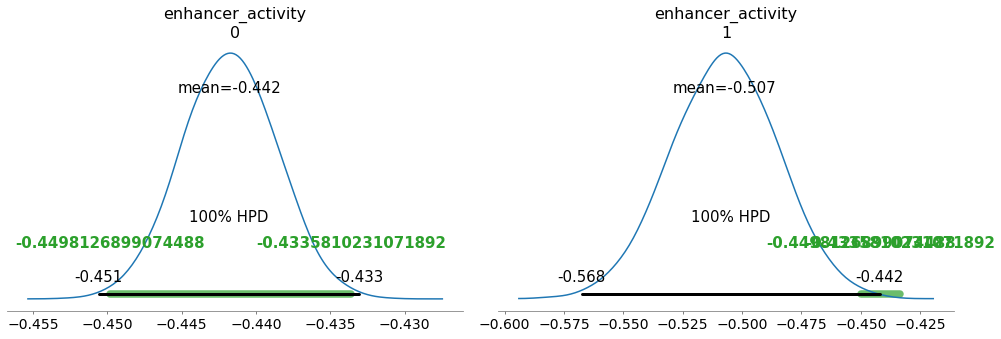

In [62]:
pm.plot_posterior(trace,var_names=['enhancer_activity'], round_to=3, 
                  color='#87ceeb',credible_interval=0.995, rope=null_rope);


/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/arviz/data/base.py:123: SyntaxWarning: More chains (18000) than draws (2). Passed array should have shape (chains, draws, *shape)
  SyntaxWarning,


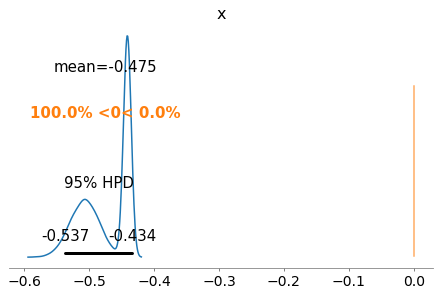

In [52]:
pm.plot_posterior(trace['enhancer_activity'], round_to=3,
                  color='#87ceeb',credible_interval=0.95, ref_val=0)
plt.show()


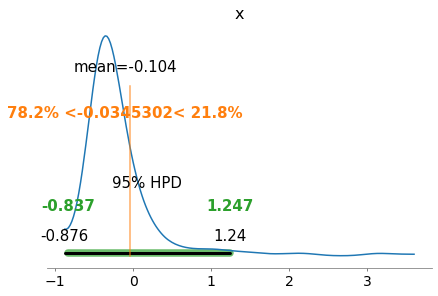

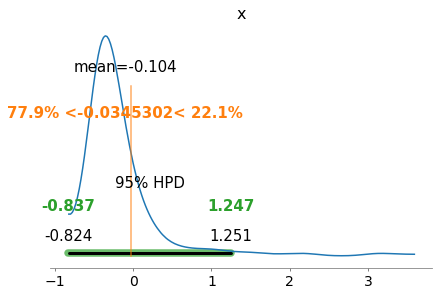

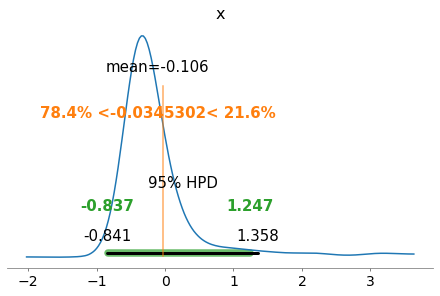

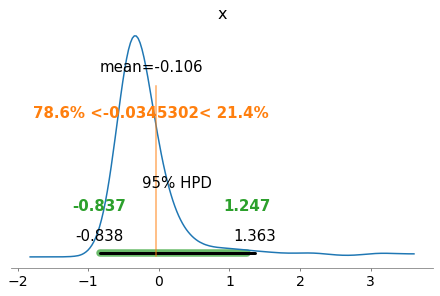

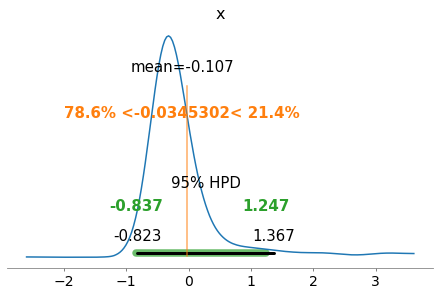

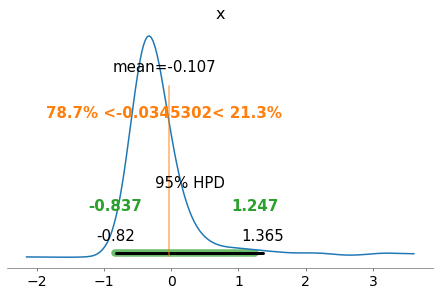

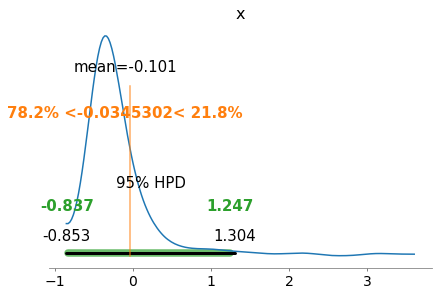

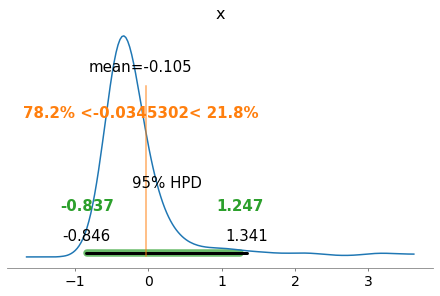

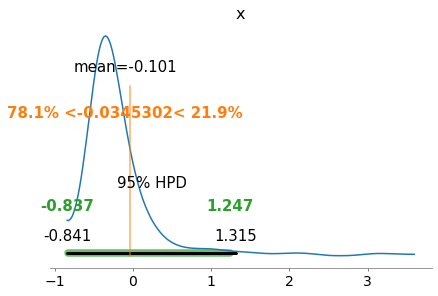

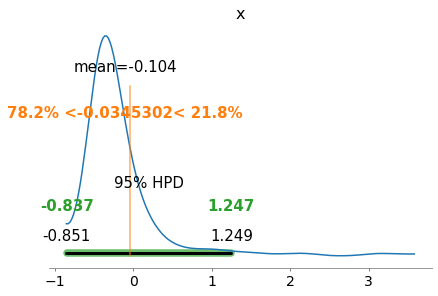

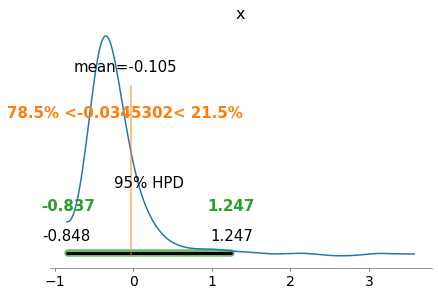

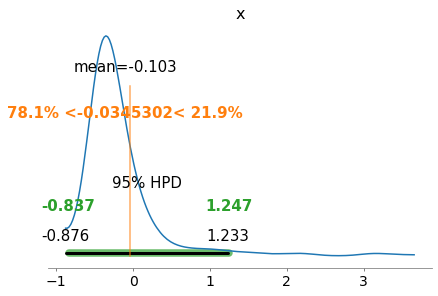

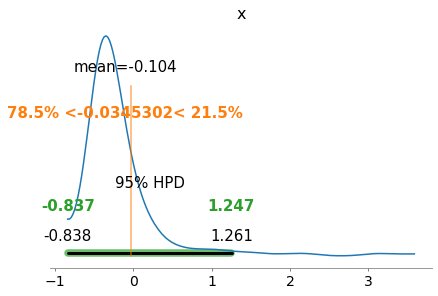

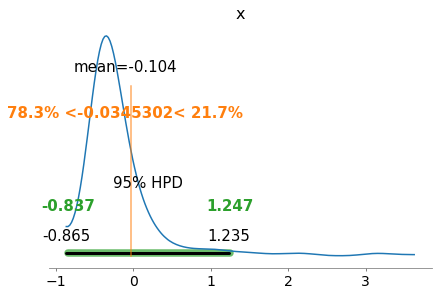

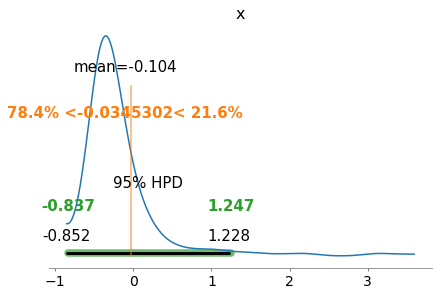

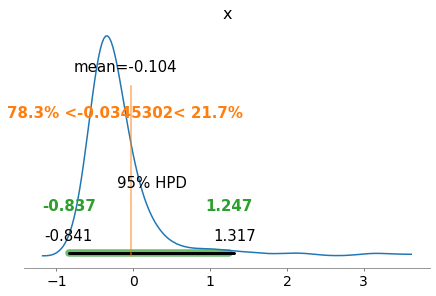

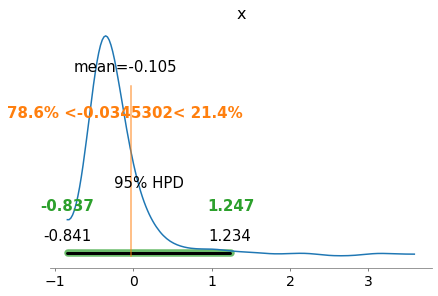

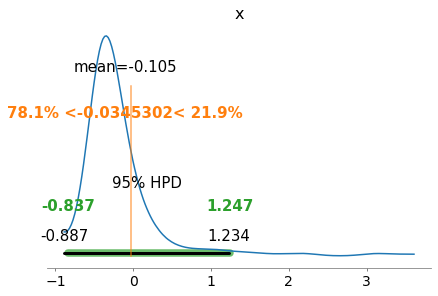

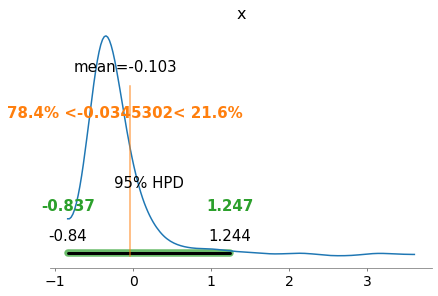

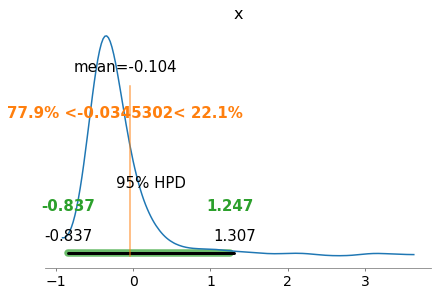

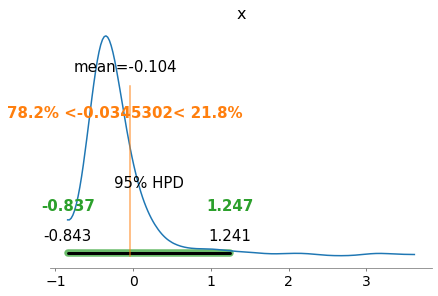

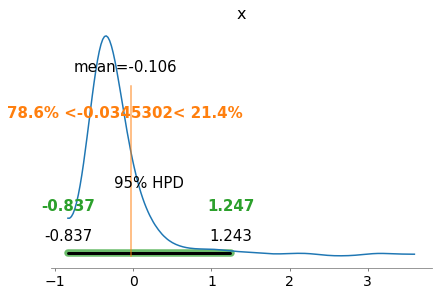

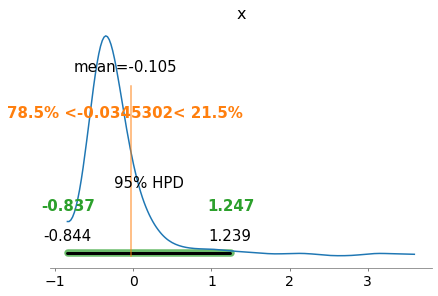

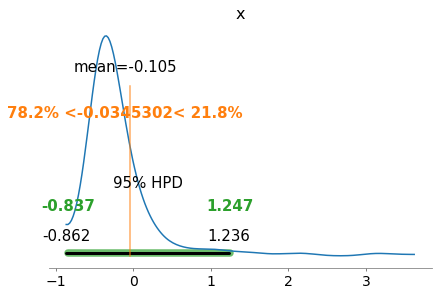

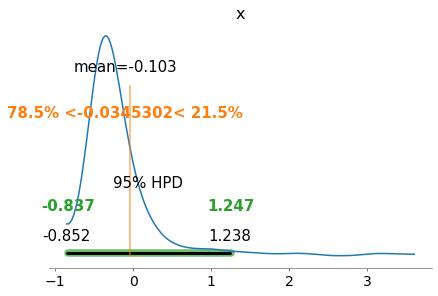

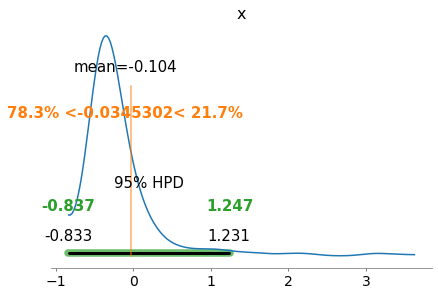

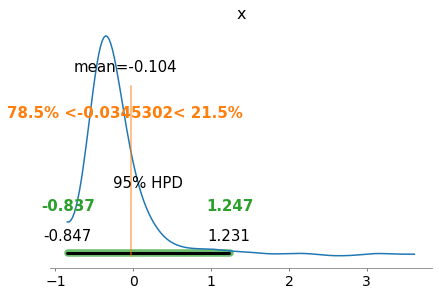

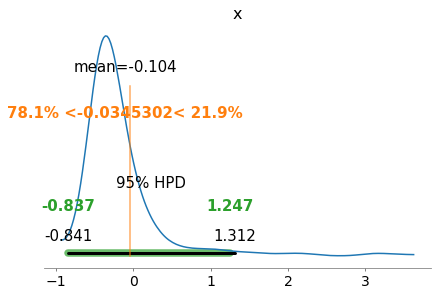

In [31]:
for i in range(get_a_peak,300):
    pm.plot_posterior(trace['enhancer_activity'][i], round_to=3,
                      color='#87ceeb',credible_interval=0.95, ref_val=e_mean,
                      rope=(-0.837,1.247))
    plt.show()



In [34]:
pm.densityplot(trace,group='prior')

ValueError: Can not extract prior from <MultiTrace: 90 chains, 500 iterations, 5 variables>! See /home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/arviz/data/converters.py for other conversion utilities.